In [1]:
# NBM Forecast and URMA Verification Data Matcher
# ================================================
# This notebook explores how to time-match NBM forecast data with URMA verification data.
#
# Key Challenge: Different naming conventions
# - NBM: Files named by INIT time + forecast hour (lead time)
# - URMA: Files named by VALID time
#
# We need to compute: valid_time = init_time + forecast_hour

from pathlib import Path
from datetime import datetime, timedelta
import re
from collections import defaultdict
import pandas as pd

# Define data paths
NBM_PATH = Path("N:/data/nbm_para")
URMA_PATH = Path("N:/data/urma")

## Step 1: Understand the Directory & File Structures

### NBM (Forecast) Structure
```
N:/data/nbm_para/
├── YYYYMMDD/           (init date)
│   ├── HH/             (init hour: 00, 01, 12, 13, etc.)
│   │   ├── {variable}_f{FFF}.grib2   (forecast hour padded to 3 digits)
```

**Example:** `N:/data/nbm_para/20250930/00/cig_vis_core_f001.grib2`
- Init date: 2025-09-30
- Init hour: 00z
- Forecast hour: 1 hour
- **Valid time: 2025-09-30 01:00z**

### URMA (Verification) Structure
```
N:/data/urma/
├── YYYYMMDD/           (valid date)
│   ├── urma2p5.tHHz.{variable}.wexp.grb2    (hourly valid time in filename)
│   ├── urma2p5.YYYYMMDDHH.{variable}.wexp.grb2   (alternate format)
```

**Example:** `urma2p5.t01z.2dvaranl_ndfd.wexp.grb2` in folder `20250930`
- **Valid time: 2025-09-30 01:00z**

In [2]:
# Let's explore what we actually have in each dataset

print("=" * 60)
print("NBM FORECAST DATA STRUCTURE")
print("=" * 60)

# Get available dates
nbm_dates = sorted([d.name for d in NBM_PATH.iterdir() if d.is_dir()])
print(f"\nAvailable NBM dates: {len(nbm_dates)} total")
print(f"Date range: {min(nbm_dates)} to {max(nbm_dates)}")
print(f"Sample dates: {nbm_dates[:5]}")

# Look at cycles (init hours) for one date
sample_nbm_date = nbm_dates[0]
nbm_cycles = sorted([c.name for c in (NBM_PATH / sample_nbm_date).iterdir() if c.is_dir()])
print(f"\nInit hours (cycles) for {sample_nbm_date}: {nbm_cycles}")

# Look at file types (variables)
sample_cycle_path = NBM_PATH / sample_nbm_date / nbm_cycles[0]
nbm_files = list(sample_cycle_path.glob("*.grib2"))
print(f"\nTotal files in {sample_nbm_date}/{nbm_cycles[0]}: {len(nbm_files)}")

# Extract unique variable prefixes
variable_pattern = re.compile(r'^(.+)_f\d{3}\.grib2$')
nbm_variables = set()
for f in nbm_files:
    match = variable_pattern.match(f.name)
    if match:
        nbm_variables.add(match.group(1))
        
print(f"\nNBM variable types found:")
for v in sorted(nbm_variables):
    print(f"  - {v}")

NBM FORECAST DATA STRUCTURE

Available NBM dates: 128 total
Date range: 20250907 to 20260114
Sample dates: ['20250907', '20250908', '20250909', '20250910', '20250911']

Init hours (cycles) for 20250907: ['00', '01', '12', '13']

Total files in 20250907/00: 400

NBM variable types found:
  - cig_vis_core
  - jfwprb_qmd
  - maxgust_qmd
  - maxrh_qmd
  - maxt_qmd
  - maxwind_qmd
  - minrh_qmd
  - mint_qmd
  - powt_sl_slr_core
  - pqpf06_qmd
  - pqpf12_qmd
  - pqpf24_qmd
  - wind_gust_dir_core


In [3]:
print("=" * 60)
print("URMA VERIFICATION DATA STRUCTURE")
print("=" * 60)

# Get available dates
urma_dates = sorted([d.name for d in URMA_PATH.iterdir() if d.is_dir()])
print(f"\nAvailable URMA dates: {len(urma_dates)} total")
print(f"Date range: {min(urma_dates)} to {max(urma_dates)}")
print(f"Sample dates: {urma_dates[:5]}")

# Look at files for one date
sample_urma_date = "20250930"  # Use a date we know exists in both
sample_urma_path = URMA_PATH / sample_urma_date
urma_files = list(sample_urma_path.glob("*.grb2"))
print(f"\nTotal files in {sample_urma_date}: {len(urma_files)}")

# Categorize URMA file types
# Pattern 1: urma2p5.tHHz.{variable}.wexp.grb2 (hourly with 't' prefix)
# Pattern 2: urma2p5.YYYYMMDDHH.{variable}.wexp.grb2 (precip files)
print("\nURMA file naming patterns found:")

hourly_pattern = re.compile(r'^urma2p5\.t(\d{2})z\.(.+)\.wexp\.grb2$')
precip_pattern = re.compile(r'^urma2p5\.(\d{10})\.(.+)\.wexp\.grb2$')

urma_hourly_vars = set()
urma_precip_vars = set()

for f in urma_files:
    m1 = hourly_pattern.match(f.name)
    m2 = precip_pattern.match(f.name)
    if m1:
        urma_hourly_vars.add(m1.group(2))
    elif m2:
        urma_precip_vars.add(m2.group(2))

print("\n  Pattern 1 - Hourly (urma2p5.tHHz.{var}.wexp.grb2):")
for v in sorted(urma_hourly_vars):
    print(f"    - {v}")
    
print("\n  Pattern 2 - Precip (urma2p5.YYYYMMDDHH.{var}.wexp.grb2):")
for v in sorted(urma_precip_vars):
    print(f"    - {v}")

URMA VERIFICATION DATA STRUCTURE

Available URMA dates: 1477 total
Date range: 20220101 to station_data
Sample dates: ['20220101', '20220102', '20220103', '20220104', '20220105']

Total files in 20250930: 78

URMA file naming patterns found:

  Pattern 1 - Hourly (urma2p5.tHHz.{var}.wexp.grb2):
    - 2dvaranl_ndfd
    - 2dvarerr_ndfd
    - maxRH_ndfd
    - minRH_ndfd

  Pattern 2 - Precip (urma2p5.YYYYMMDDHH.{var}.wexp.grb2):
    - pcp_01h
    - pcp_06h


## Step 2: Define Parsing Functions

We need functions to:
1. **Parse NBM filenames** → extract init time, forecast hour, compute valid time
2. **Parse URMA filenames** → extract valid time directly
3. **Build file catalogs** indexed by valid time

In [4]:
def parse_nbm_file(filepath: Path) -> dict:
    """
    Parse NBM forecast file path to extract timing information.
    
    Path structure: {base}/{YYYYMMDD}/{HH}/{variable}_f{FFF}.grib2
    
    Returns dict with:
        - filepath: original Path object
        - init_date: str (YYYYMMDD)
        - init_hour: int (0-23)
        - init_time: datetime
        - forecast_hour: int
        - valid_time: datetime (computed as init_time + forecast_hour)
        - variable: str (file prefix before _fXXX)
    """
    # Extract components from path
    filename = filepath.name
    init_hour_str = filepath.parent.name  # e.g., "00"
    init_date_str = filepath.parent.parent.name  # e.g., "20250930"
    
    # Parse filename: {variable}_f{FFF}.grib2
    match = re.match(r'^(.+)_f(\d{3})\.grib2$', filename)
    if not match:
        return None
    
    variable = match.group(1)
    forecast_hour = int(match.group(2))
    
    # Compute init_time
    init_hour = int(init_hour_str)
    init_time = datetime.strptime(init_date_str, "%Y%m%d") + timedelta(hours=init_hour)
    
    # Compute valid_time
    valid_time = init_time + timedelta(hours=forecast_hour)
    
    return {
        'filepath': filepath,
        'init_date': init_date_str,
        'init_hour': init_hour,
        'init_time': init_time,
        'forecast_hour': forecast_hour,
        'valid_time': valid_time,
        'variable': variable
    }

# Test it
test_nbm_path = NBM_PATH / "20250930" / "00" / "cig_vis_core_f001.grib2"
test_result = parse_nbm_file(test_nbm_path)
print("NBM Parse Test:")
print(f"  File: {test_nbm_path.name}")
print(f"  Init time: {test_result['init_time']}")
print(f"  Forecast hour: {test_result['forecast_hour']}")
print(f"  Valid time: {test_result['valid_time']}  ← This is what we match on!")
print(f"  Variable: {test_result['variable']}")

NBM Parse Test:
  File: cig_vis_core_f001.grib2
  Init time: 2025-09-30 00:00:00
  Forecast hour: 1
  Valid time: 2025-09-30 01:00:00  ← This is what we match on!
  Variable: cig_vis_core


In [5]:
def parse_urma_file(filepath: Path) -> dict:
    """
    Parse URMA verification file path to extract timing information.
    
    URMA has TWO naming patterns:
    
    Pattern 1 (hourly): urma2p5.tHHz.{variable}.wexp.grb2
        - Valid time is folder date + hour from filename
        
    Pattern 2 (precip): urma2p5.YYYYMMDDHH.{variable}.wexp.grb2
        - Valid time embedded directly in filename
    
    Returns dict with:
        - filepath: original Path object
        - valid_time: datetime
        - variable: str
        - file_type: 'hourly' or 'precip'
    """
    filename = filepath.name
    folder_date = filepath.parent.name  # e.g., "20250930"
    
    # Try Pattern 1: hourly files (urma2p5.tHHz.{variable}.wexp.grb2)
    hourly_match = re.match(r'^urma2p5\.t(\d{2})z\.(.+)\.wexp\.grb2$', filename)
    if hourly_match:
        hour = int(hourly_match.group(1))
        variable = hourly_match.group(2)
        valid_time = datetime.strptime(folder_date, "%Y%m%d") + timedelta(hours=hour)
        return {
            'filepath': filepath,
            'valid_time': valid_time,
            'variable': variable,
            'file_type': 'hourly'
        }
    
    # Try Pattern 2: precip files (urma2p5.YYYYMMDDHH.{variable}.wexp.grb2)
    precip_match = re.match(r'^urma2p5\.(\d{10})\.(.+)\.wexp\.grb2$', filename)
    if precip_match:
        valid_time_str = precip_match.group(1)
        variable = precip_match.group(2)
        valid_time = datetime.strptime(valid_time_str, "%Y%m%d%H")
        return {
            'filepath': filepath,
            'valid_time': valid_time,
            'variable': variable,
            'file_type': 'precip'
        }
    
    return None

# Test both patterns
print("URMA Parse Tests:")
print()

test_urma_hourly = URMA_PATH / "20250930" / "urma2p5.t01z.2dvaranl_ndfd.wexp.grb2"
result1 = parse_urma_file(test_urma_hourly)
print(f"Pattern 1 (hourly): {test_urma_hourly.name}")
print(f"  Valid time: {result1['valid_time']}")
print(f"  Variable: {result1['variable']}")
print()

test_urma_precip = URMA_PATH / "20250930" / "urma2p5.2025093006.pcp_06h.wexp.grb2"
result2 = parse_urma_file(test_urma_precip)
print(f"Pattern 2 (precip): {test_urma_precip.name}")
print(f"  Valid time: {result2['valid_time']}")
print(f"  Variable: {result2['variable']}")

URMA Parse Tests:

Pattern 1 (hourly): urma2p5.t01z.2dvaranl_ndfd.wexp.grb2
  Valid time: 2025-09-30 01:00:00
  Variable: 2dvaranl_ndfd

Pattern 2 (precip): urma2p5.2025093006.pcp_06h.wexp.grb2
  Valid time: 2025-09-30 06:00:00
  Variable: pcp_06h


## Step 3: Build File Catalogs

Now we'll scan both directories and build catalogs indexed by valid time. This allows us to efficiently find matching files.

In [6]:
def build_nbm_catalog(base_path: Path, date_filter: list = None) -> dict:
    """
    Build a catalog of NBM files indexed by valid_time.
    
    Returns:
        dict: {valid_time: {variable: [list of file_info dicts]}}
        
    Each valid_time can have multiple forecast files from different init times
    (different lead times for the same valid time).
    """
    catalog = defaultdict(lambda: defaultdict(list))
    file_count = 0
    
    # Iterate through date folders
    for date_dir in base_path.iterdir():
        if not date_dir.is_dir():
            continue
        if date_filter and date_dir.name not in date_filter:
            continue
            
        # Iterate through cycle (init hour) folders
        for cycle_dir in date_dir.iterdir():
            if not cycle_dir.is_dir():
                continue
                
            # Parse all grib2 files
            for grib_file in cycle_dir.glob("*.grib2"):
                parsed = parse_nbm_file(grib_file)
                if parsed:
                    valid_time = parsed['valid_time']
                    variable = parsed['variable']
                    catalog[valid_time][variable].append(parsed)
                    file_count += 1
    
    print(f"NBM catalog built: {file_count} files indexed")
    print(f"Unique valid times: {len(catalog)}")
    
    return dict(catalog)

# Build catalog for a sample date to test (full scan would take longer)
sample_dates = ["20250930"]
nbm_catalog = build_nbm_catalog(NBM_PATH, date_filter=sample_dates)

NBM catalog built: 890 files indexed
Unique valid times: 103


In [7]:
def build_urma_catalog(base_path: Path, date_filter: list = None) -> dict:
    """
    Build a catalog of URMA files indexed by valid_time.
    
    Returns:
        dict: {valid_time: {variable: file_info dict}}
        
    Unlike NBM, URMA has one file per valid time per variable.
    """
    catalog = defaultdict(dict)
    file_count = 0
    
    # Iterate through date folders
    for date_dir in base_path.iterdir():
        if not date_dir.is_dir():
            continue
        if date_filter and date_dir.name not in date_filter:
            continue
            
        # Parse all grb2 files
        for grb_file in date_dir.glob("*.grb2"):
            parsed = parse_urma_file(grb_file)
            if parsed:
                valid_time = parsed['valid_time']
                variable = parsed['variable']
                catalog[valid_time][variable] = parsed
                file_count += 1
    
    print(f"URMA catalog built: {file_count} files indexed")
    print(f"Unique valid times: {len(catalog)}")
    
    return dict(catalog)

# Build URMA catalog for the same dates
urma_catalog = build_urma_catalog(URMA_PATH, date_filter=sample_dates)

URMA catalog built: 78 files indexed
Unique valid times: 24


## Step 4: Explore the Catalogs

Let's examine what valid times we have and see how the NBM forecast files map to them.

In [8]:
# Show valid times available in each catalog
nbm_valid_times = sorted(nbm_catalog.keys())
urma_valid_times = sorted(urma_catalog.keys())

print("NBM Valid Times (computed from init + forecast hour):")
print(f"  Range: {nbm_valid_times[0]} to {nbm_valid_times[-1]}")
print(f"  Count: {len(nbm_valid_times)}")
print()

print("URMA Valid Times:")
print(f"  Range: {urma_valid_times[0]} to {urma_valid_times[-1]}")
print(f"  Count: {len(urma_valid_times)}")
print()

# Find overlapping valid times
common_times = set(nbm_valid_times) & set(urma_valid_times)
print(f"COMMON Valid Times (matchable): {len(common_times)}")
if common_times:
    common_sorted = sorted(common_times)
    print(f"  Range: {common_sorted[0]} to {common_sorted[-1]}")

NBM Valid Times (computed from init + forecast hour):
  Range: 2025-09-30 01:00:00 to 2025-10-08 06:00:00
  Count: 103

URMA Valid Times:
  Range: 2025-09-30 00:00:00 to 2025-09-30 23:00:00
  Count: 24

COMMON Valid Times (matchable): 23
  Range: 2025-09-30 01:00:00 to 2025-09-30 23:00:00


In [9]:
# Let's examine a specific valid time to see how NBM files map to it
# Multiple NBM init times can produce the same valid time (different lead times)

sample_valid_time = sorted(common_times)[0] if common_times else nbm_valid_times[0]
print(f"Examining valid time: {sample_valid_time}")
print("=" * 60)

print("\nNBM files with this valid time:")
print("-" * 40)

if sample_valid_time in nbm_catalog:
    for var, files in nbm_catalog[sample_valid_time].items():
        print(f"\nVariable: {var}")
        for f in sorted(files, key=lambda x: x['forecast_hour']):
            print(f"  Init: {f['init_time']} + {f['forecast_hour']:3d}h → Valid: {f['valid_time']}")
            print(f"       File: {f['filepath'].name}")

print("\n" + "=" * 60)
print("\nURMA files with this valid time:")
print("-" * 40)

if sample_valid_time in urma_catalog:
    for var, f in urma_catalog[sample_valid_time].items():
        print(f"  {var}: {f['filepath'].name}")

Examining valid time: 2025-09-30 01:00:00

NBM files with this valid time:
----------------------------------------

Variable: cig_vis_core
  Init: 2025-09-30 00:00:00 +   1h → Valid: 2025-09-30 01:00:00
       File: cig_vis_core_f001.grib2

Variable: powt_sl_slr_core
  Init: 2025-09-30 00:00:00 +   1h → Valid: 2025-09-30 01:00:00
       File: powt_sl_slr_core_f001.grib2

Variable: wind_gust_dir_core
  Init: 2025-09-30 00:00:00 +   1h → Valid: 2025-09-30 01:00:00
       File: wind_gust_dir_core_f001.grib2


URMA files with this valid time:
----------------------------------------
  2dvaranl_ndfd: urma2p5.t01z.2dvaranl_ndfd.wexp.grb2
  pcp_01h: urma2p5.2025093001.pcp_01h.wexp.grb2
  2dvarerr_ndfd: urma2p5.t01z.2dvarerr_ndfd.wexp.grb2


## Step 5: Build the Final Pairing Structure

Now we create the actual pairing between verification and forecast files. The structure will be:

```python
{
    valid_time: {
        'urma': {variable: file_info, ...},
        'nbm': {variable: [list of forecasts at different lead times], ...}
    }
}
```

This allows for verification against multiple forecast lead times for the same valid time.

In [10]:
def build_verification_pairs(nbm_catalog: dict, urma_catalog: dict) -> dict:
    """
    Build a unified structure pairing URMA verification files with NBM forecasts
    for each valid time.
    
    Returns:
        dict: {
            valid_time: {
                'urma': {variable: file_info},
                'nbm': {variable: [file_info, ...]},
                'has_both': bool  # True if both URMA and NBM data exist
            }
        }
    """
    # Get all unique valid times from both catalogs
    all_valid_times = set(nbm_catalog.keys()) | set(urma_catalog.keys())
    
    pairs = {}
    
    for vt in sorted(all_valid_times):
        pairs[vt] = {
            'urma': urma_catalog.get(vt, {}),
            'nbm': nbm_catalog.get(vt, {}),
            'has_both': vt in nbm_catalog and vt in urma_catalog
        }
    
    # Statistics
    total = len(pairs)
    both = sum(1 for p in pairs.values() if p['has_both'])
    nbm_only = sum(1 for p in pairs.values() if p['nbm'] and not p['urma'])
    urma_only = sum(1 for p in pairs.values() if p['urma'] and not p['nbm'])
    
    print("Verification Pairs Summary:")
    print(f"  Total valid times: {total}")
    print(f"  Both NBM & URMA:   {both} (usable for verification)")
    print(f"  NBM only:          {nbm_only}")
    print(f"  URMA only:         {urma_only}")
    
    return pairs

verification_pairs = build_verification_pairs(nbm_catalog, urma_catalog)

Verification Pairs Summary:
  Total valid times: 104
  Both NBM & URMA:   23 (usable for verification)
  NBM only:          80
  URMA only:         1


In [11]:
# Create a DataFrame view of the pairs for easier inspection
def pairs_to_dataframe(pairs: dict) -> pd.DataFrame:
    """Convert verification pairs to a DataFrame for inspection."""
    rows = []
    
    for vt, data in pairs.items():
        nbm_vars = list(data['nbm'].keys()) if data['nbm'] else []
        urma_vars = list(data['urma'].keys()) if data['urma'] else []
        
        # Count forecasts per NBM variable (different lead times)
        nbm_forecast_counts = {
            var: len(files) for var, files in data['nbm'].items()
        } if data['nbm'] else {}
        
        rows.append({
            'valid_time': vt,
            'has_both': data['has_both'],
            'nbm_variables': len(nbm_vars),
            'urma_variables': len(urma_vars),
            'nbm_var_list': ', '.join(sorted(nbm_vars)[:3]) + ('...' if len(nbm_vars) > 3 else ''),
            'urma_var_list': ', '.join(sorted(urma_vars)[:3]) + ('...' if len(urma_vars) > 3 else ''),
            'nbm_total_files': sum(nbm_forecast_counts.values())
        })
    
    return pd.DataFrame(rows)

pairs_df = pairs_to_dataframe(verification_pairs)
print("Verification Pairs DataFrame (sample):")
print()
pairs_df[pairs_df['has_both']].head(10)

Verification Pairs DataFrame (sample):



valid_time  has_both  nbm_variables  urma_variables  \
1  2025-09-30 01:00:00      True              3               3   
2  2025-09-30 02:00:00      True              3               3   
3  2025-09-30 03:00:00      True              4               3   
4  2025-09-30 04:00:00      True              3               3   
5  2025-09-30 05:00:00      True              3               3   
6  2025-09-30 06:00:00      True              5               4   
7  2025-09-30 07:00:00      True              3               3   
8  2025-09-30 08:00:00      True              3               4   
9  2025-09-30 09:00:00      True              4               3   
10 2025-09-30 10:00:00      True              3               3   

                                         nbm_var_list  \
1   cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
2   cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
3       cig_vis_core, jfwprb_qmd, powt_sl_slr_core...   
4   cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
5   cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
6       cig_vis_core, jfwprb_qmd, powt_sl_slr_core...   
7   cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
8   cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
9       cig_vis_core, jfwprb_qmd, powt_sl_slr_core...   
10  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   

                                  urma_var_list  nbm_total_files  
1         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3  
2         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3  
3         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                4  
4         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3  
5         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3  
6      2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h...                5  
7         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3  
8   2dvaranl_ndfd, 2dvarerr_ndfd, minRH_ndfd...                3  
9         2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                4  
10        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3

## Step 6: Helper Functions for Accessing Pairs

Convenience functions to query the paired data:

In [12]:
def get_verification_data(pairs: dict, valid_time: datetime, 
                          nbm_variable: str = None, 
                          lead_time: int = None) -> dict:
    """
    Get verification/forecast file pair for a specific valid time.
    
    Args:
        pairs: The verification_pairs dict
        valid_time: datetime of the valid time
        nbm_variable: specific NBM variable to filter (optional)
        lead_time: specific forecast lead time in hours (optional)
    
    Returns:
        dict with 'urma' and 'nbm' file info
    """
    if valid_time not in pairs:
        return None
    
    data = pairs[valid_time]
    result = {'urma': data['urma'], 'nbm': {}}
    
    if nbm_variable:
        # Filter to specific variable
        if nbm_variable in data['nbm']:
            forecasts = data['nbm'][nbm_variable]
            if lead_time is not None:
                # Filter to specific lead time
                forecasts = [f for f in forecasts if f['forecast_hour'] == lead_time]
            result['nbm'] = {nbm_variable: forecasts}
    else:
        # All variables
        if lead_time is not None:
            # Filter all variables to specific lead time
            for var, files in data['nbm'].items():
                filtered = [f for f in files if f['forecast_hour'] == lead_time]
                if filtered:
                    result['nbm'][var] = filtered
        else:
            result['nbm'] = data['nbm']
    
    return result


def list_available_lead_times(pairs: dict, valid_time: datetime, 
                               variable: str = None) -> list:
    """
    List available forecast lead times for a given valid time.
    """
    if valid_time not in pairs:
        return []
    
    data = pairs[valid_time]['nbm']
    lead_times = set()
    
    for var, files in data.items():
        if variable is None or var == variable:
            for f in files:
                lead_times.add(f['forecast_hour'])
    
    return sorted(lead_times)


# Example usage
print("Example: Query for a specific valid time")
print("=" * 60)
example_vt = sorted([vt for vt in verification_pairs if verification_pairs[vt]['has_both']])[0]
print(f"Valid time: {example_vt}")
print()

available_leads = list_available_lead_times(verification_pairs, example_vt)
print(f"Available lead times (hours): {available_leads}")
print()

# Get data for a specific lead time
if available_leads:
    sample_lead = available_leads[0]
    data = get_verification_data(verification_pairs, example_vt, lead_time=sample_lead)
    print(f"Files for lead time = {sample_lead}h:")
    print(f"  NBM variables: {list(data['nbm'].keys())}")
    print(f"  URMA variables: {list(data['urma'].keys())}")

Example: Query for a specific valid time
Valid time: 2025-09-30 01:00:00

Available lead times (hours): [1]

Files for lead time = 1h:
  NBM variables: ['cig_vis_core', 'powt_sl_slr_core', 'wind_gust_dir_core']
  URMA variables: ['2dvaranl_ndfd', 'pcp_01h', '2dvarerr_ndfd']


## Summary

We've built a system to match NBM forecast files with URMA verification files based on valid time:

### Key Concepts:

1. **NBM (Forecast)**: `valid_time = init_time + forecast_hour`
   - Path: `{base}/{YYYYMMDD}/{HH}/{variable}_f{FFF}.grib2`
   - Multiple forecasts can have the same valid time (different init times/lead times)

2. **URMA (Verification)**: Valid time directly in filename
   - Pattern 1: `urma2p5.t{HH}z.{variable}.wexp.grb2` (folder provides date)
   - Pattern 2: `urma2p5.{YYYYMMDDHH}.{variable}.wexp.grb2` (precip files)

3. **Pairing Structure**:
   ```python
   verification_pairs[valid_time] = {
       'urma': {variable: file_info},
       'nbm': {variable: [file_info_list]},  # multiple lead times
       'has_both': bool
   }
   ```

### Next Steps:
- Variable name mapping between NBM and URMA
- Expand to full date range
- Load and compare actual data

## Step 7: Expand to Full Date Range

Now we'll scan all available dates in both datasets. This may take a moment as we're indexing many files.

In [13]:
# First, let's see what dates are available in each dataset

print("Available dates in NBM (forecast) data:")
nbm_all_dates = sorted([d.name for d in NBM_PATH.iterdir() if d.is_dir()])
print(f"  Total: {len(nbm_all_dates)} dates")
print(f"  Range: {min(nbm_all_dates)} to {max(nbm_all_dates)}")
print(f"  Dates: {nbm_all_dates}")
print()

print("Available dates in URMA (verification) data:")
urma_all_dates = sorted([d.name for d in URMA_PATH.iterdir() if d.is_dir()])
print(f"  Total: {len(urma_all_dates)} dates")
print(f"  Range: {min(urma_all_dates)} to {max(urma_all_dates)}")
print()

# Find common dates (dates where both datasets have folders)
common_dates = sorted(set(nbm_all_dates) & set(urma_all_dates))
print(f"Common dates (both have data): {len(common_dates)}")
print(f"  {common_dates}")

Available dates in NBM (forecast) data:
  Total: 128 dates
  Range: 20250907 to 20260114
  Dates: ['20250907', '20250908', '20250909', '20250910', '20250911', '20250912', '20250913', '20250914', '20250915', '20250916', '20250917', '20250918', '20250919', '20250920', '20250921', '20250922', '20250923', '20250924', '20250925', '20250926', '20250927', '20250928', '20250929', '20250930', '20251001', '20251002', '20251003', '20251004', '20251005', '20251006', '20251007', '20251008', '20251009', '20251010', '20251011', '20251012', '20251013', '20251014', '20251015', '20251016', '20251017', '20251018', '20251019', '20251020', '20251021', '20251022', '20251023', '20251026', '20251027', '20251028', '20251029', '20251030', '20251031', '20251101', '20251102', '20251103', '20251104', '20251105', '20251106', '20251107', '20251108', '20251109', '20251110', '20251111', '20251112', '20251113', '20251114', '20251115', '20251116', '20251117', '20251118', '20251119', '20251120', '20251121', '20251122', '

In [14]:
from tqdm.auto import tqdm
import time

def build_nbm_catalog_full(base_path: Path, date_filter: list = None, show_progress: bool = True) -> dict:
    """
    Build a catalog of NBM files indexed by valid_time (with progress bar).
    
    Returns:
        dict: {valid_time: {variable: [list of file_info dicts]}}
    """
    catalog = defaultdict(lambda: defaultdict(list))
    file_count = 0
    
    # Get list of date directories to process
    date_dirs = [d for d in base_path.iterdir() if d.is_dir()]
    if date_filter:
        date_dirs = [d for d in date_dirs if d.name in date_filter]
    date_dirs = sorted(date_dirs, key=lambda x: x.name)
    
    iterator = tqdm(date_dirs, desc="Scanning NBM dates") if show_progress else date_dirs
    
    for date_dir in iterator:
        # Iterate through cycle (init hour) folders
        for cycle_dir in date_dir.iterdir():
            if not cycle_dir.is_dir():
                continue
                
            # Parse all grib2 files
            for grib_file in cycle_dir.glob("*.grib2"):
                parsed = parse_nbm_file(grib_file)
                if parsed:
                    valid_time = parsed['valid_time']
                    variable = parsed['variable']
                    catalog[valid_time][variable].append(parsed)
                    file_count += 1
    
    print(f"\nNBM catalog complete: {file_count:,} files indexed")
    print(f"Unique valid times: {len(catalog):,}")
    
    return dict(catalog)


def build_urma_catalog_full(base_path: Path, date_filter: list = None, show_progress: bool = True) -> dict:
    """
    Build a catalog of URMA files indexed by valid_time (with progress bar).
    
    Returns:
        dict: {valid_time: {variable: file_info dict}}
    """
    catalog = defaultdict(dict)
    file_count = 0
    
    # Get list of date directories to process
    date_dirs = [d for d in base_path.iterdir() if d.is_dir()]
    if date_filter:
        date_dirs = [d for d in date_dirs if d.name in date_filter]
    date_dirs = sorted(date_dirs, key=lambda x: x.name)
    
    iterator = tqdm(date_dirs, desc="Scanning URMA dates") if show_progress else date_dirs
    
    for date_dir in iterator:
        # Parse all grb2 files
        for grb_file in date_dir.glob("*.grb2"):
            parsed = parse_urma_file(grb_file)
            if parsed:
                valid_time = parsed['valid_time']
                variable = parsed['variable']
                catalog[valid_time][variable] = parsed
                file_count += 1
    
    print(f"\nURMA catalog complete: {file_count:,} files indexed")
    print(f"Unique valid times: {len(catalog):,}")
    
    return dict(catalog)

In [15]:
# Build the FULL catalogs (all available dates)
# This will take a bit of time depending on how many files exist

print("Building full NBM catalog...")
print("=" * 60)
start_time = time.time()
nbm_catalog_full = build_nbm_catalog_full(NBM_PATH)
nbm_time = time.time() - start_time
print(f"NBM scan completed in {nbm_time:.1f} seconds")

print()
print("Building full URMA catalog...")
print("=" * 60)
start_time = time.time()
urma_catalog_full = build_urma_catalog_full(URMA_PATH)
urma_time = time.time() - start_time
print(f"URMA scan completed in {urma_time:.1f} seconds")

Building full NBM catalog...


Scanning NBM dates:   0%|          | 0/128 [00:00<?, ?it/s]


NBM catalog complete: 108,715 files indexed
Unique valid times: 3,165
NBM scan completed in 10.3 seconds

Building full URMA catalog...


Scanning URMA dates:   0%|          | 0/1477 [00:00<?, ?it/s]


URMA catalog complete: 81,781 files indexed
Unique valid times: 35,119
URMA scan completed in 24.3 seconds


In [16]:
# Build the full verification pairs structure
print("Building full verification pairs...")
print("=" * 60)
verification_pairs_full = build_verification_pairs(nbm_catalog_full, urma_catalog_full)

Building full verification pairs...
Verification Pairs Summary:
  Total valid times: 35181
  Both NBM & URMA:   3103 (usable for verification)
  NBM only:          62
  URMA only:         32016


In [17]:
# Detailed analysis of the full dataset
print("=" * 60)
print("FULL DATASET ANALYSIS")
print("=" * 60)

# Valid time ranges
nbm_valid_times_full = sorted(nbm_catalog_full.keys())
urma_valid_times_full = sorted(urma_catalog_full.keys())
common_valid_times = sorted(set(nbm_valid_times_full) & set(urma_valid_times_full))

print("\nNBM Valid Time Coverage:")
print(f"  First: {nbm_valid_times_full[0]}")
print(f"  Last:  {nbm_valid_times_full[-1]}")
print(f"  Total unique times: {len(nbm_valid_times_full):,}")

print("\nURMA Valid Time Coverage:")
print(f"  First: {urma_valid_times_full[0]}")
print(f"  Last:  {urma_valid_times_full[-1]}")
print(f"  Total unique times: {len(urma_valid_times_full):,}")

print("\nMATCHABLE Valid Times (both datasets):")
print(f"  First: {common_valid_times[0]}")
print(f"  Last:  {common_valid_times[-1]}")
print(f"  Total: {len(common_valid_times):,}")

# Variable coverage
all_nbm_vars = set()
for vt_data in nbm_catalog_full.values():
    all_nbm_vars.update(vt_data.keys())

all_urma_vars = set()
for vt_data in urma_catalog_full.values():
    all_urma_vars.update(vt_data.keys())

print("\nNBM Variables Available:")
for v in sorted(all_nbm_vars):
    print(f"  - {v}")

print("\nURMA Variables Available:")
for v in sorted(all_urma_vars):
    print(f"  - {v}")

FULL DATASET ANALYSIS

NBM Valid Time Coverage:
  First: 2025-09-07 01:00:00
  Last:  2026-01-22 00:00:00
  Total unique times: 3,165

URMA Valid Time Coverage:
  First: 2022-01-01 00:00:00
  Last:  2026-01-15 16:00:00
  Total unique times: 35,119

MATCHABLE Valid Times (both datasets):
  First: 2025-09-07 01:00:00
  Last:  2026-01-15 16:00:00
  Total: 3,103

NBM Variables Available:
  - cig_vis_core
  - jfwprb_qmd
  - maxgust_qmd
  - maxrh_qmd
  - maxt_qmd
  - maxwind_qmd
  - minrh_qmd
  - mint_qmd
  - powt_sl_slr_core
  - pqpf06_qmd
  - pqpf12_qmd
  - pqpf24_qmd
  - pwpf06_core
  - pwpf24_core
  - wind_gust_dir_core

URMA Variables Available:
  - 2dvaranl_ndfd
  - 2dvarerr_ndfd
  - maxRH_ndfd
  - minRH_ndfd
  - pcp_01h
  - pcp_06h


In [18]:
# Create a comprehensive DataFrame of all matchable pairs
pairs_df_full = pairs_to_dataframe(verification_pairs_full)

# Filter to only matchable pairs (has_both = True)
matchable_df = pairs_df_full[pairs_df_full['has_both']].copy()
matchable_df['date'] = matchable_df['valid_time'].dt.date
matchable_df['hour'] = matchable_df['valid_time'].dt.hour

print(f"Matchable pairs: {len(matchable_df):,} valid times")
print()
print("Sample of matchable pairs:")
matchable_df.head(10)

Matchable pairs: 3,103 valid times

Sample of matchable pairs:


valid_time  has_both  nbm_variables  urma_variables  \
31984 2025-09-07 01:00:00      True              3               3   
31985 2025-09-07 02:00:00      True              3               3   
31986 2025-09-07 03:00:00      True              4               3   
31987 2025-09-07 04:00:00      True              3               3   
31988 2025-09-07 05:00:00      True              3               3   
31989 2025-09-07 06:00:00      True              5               4   
31990 2025-09-07 07:00:00      True              3               3   
31991 2025-09-07 08:00:00      True              3               4   
31992 2025-09-07 09:00:00      True              4               3   
31993 2025-09-07 10:00:00      True              3               3   

                                            nbm_var_list  \
31984  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
31985  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
31986      cig_vis_core, jfwprb_qmd, powt_sl_slr_core...   
31987  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
31988  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
31989      cig_vis_core, jfwprb_qmd, powt_sl_slr_core...   
31990  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
31991  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   
31992      cig_vis_core, jfwprb_qmd, powt_sl_slr_core...   
31993  cig_vis_core, powt_sl_slr_core, wind_gust_dir_...   

                                     urma_var_list  nbm_total_files  \
31984        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3   
31985        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3   
31986        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                4   
31987        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3   
31988        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3   
31989     2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h...                5   
31990        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3   
31991  2dvaranl_ndfd, 2dvarerr_ndfd, minRH_ndfd...                3   
31992        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                4   
31993        2dvaranl_ndfd, 2dvarerr_ndfd, pcp_01h                3   

             date  hour  
31984  2025-09-07     1  
31985  2025-09-07     2  
31986  2025-09-07     3  
31987  2025-09-07     4  
31988  2025-09-07     5  
31989  2025-09-07     6  
31990  2025-09-07     7  
31991  2025-09-07     8  
31992  2025-09-07     9  
31993  2025-09-07    10

In [19]:
# Summary statistics by date
print("Coverage by Date:")
print("=" * 60)
coverage_by_date = matchable_df.groupby('date').agg({
    'valid_time': 'count',
    'nbm_total_files': 'sum',
    'nbm_variables': 'mean',
    'urma_variables': 'mean'
}).rename(columns={
    'valid_time': 'hours_covered',
    'nbm_total_files': 'total_nbm_files',
    'nbm_variables': 'avg_nbm_vars',
    'urma_variables': 'avg_urma_vars'
})

coverage_by_date

Coverage by Date:


hours_covered  total_nbm_files  avg_nbm_vars  avg_urma_vars
date                                                                   
2025-09-07             23              122      3.695652       3.217391
2025-09-08             24              318      4.375000       3.250000
2025-09-09             24              450      4.416667       3.250000
2025-09-10             24              562      4.416667       3.250000
2025-09-11             24              656      4.416667       3.250000
...                   ...              ...           ...            ...
2026-01-11             24              890      4.416667       3.250000
2026-01-12             24              890      4.416667       3.250000
2026-01-13             24              890      4.416667       3.250000
2026-01-14             24              886      4.416667       3.250000
2026-01-15             17              573      4.470588       3.117647

[131 rows x 4 columns]

In [20]:
# Analyze lead time distribution in the matchable data
print("Lead Time Distribution Analysis:")
print("=" * 60)

lead_time_counts = defaultdict(int)
for vt in common_valid_times:
    leads = list_available_lead_times(verification_pairs_full, vt)
    for lead in leads:
        lead_time_counts[lead] += 1

lead_df = pd.DataFrame([
    {'lead_time_hours': k, 'valid_times_with_this_lead': v} 
    for k, v in sorted(lead_time_counts.items())
])

print(f"Lead times available: {len(lead_df)}")
print(f"Range: {lead_df['lead_time_hours'].min()}h to {lead_df['lead_time_hours'].max()}h")
print()
print("Lead time availability (how many valid times have each lead):")
lead_df

Lead Time Distribution Analysis:
Lead times available: 111
Range: 1h to 186h

Lead time availability (how many valid times have each lead):


lead_time_hours  valid_times_with_this_lead
0                  1                         238
1                  2                         238
2                  3                         255
3                  4                         238
4                  5                         238
..               ...                         ...
106              167                         231
107              168                         243
108              174                         241
109              179                         230
110              186                         119

[111 rows x 2 columns]

## Step 8: Variable Mapping Analysis

We need to map NBM forecast variables to URMA verification variables. This is complex because:
1. Naming conventions differ significantly
2. Some URMA files (like `2dvaranl_ndfd`) are **composite files** containing multiple variables
3. Some NBM variables may not have direct URMA equivalents

Let's first inspect the actual GRIB contents to understand what's inside each file.

In [21]:
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Let's inspect the contents of each URMA file type
print("=" * 80)
print("URMA FILE CONTENTS INSPECTION")
print("=" * 80)

# Get sample files for each URMA variable type
sample_urma_date_path = URMA_PATH / "20250930"

for urma_var in sorted(all_urma_vars):
    print(f"\n{'─' * 80}")
    print(f"URMA File Type: {urma_var}")
    print(f"{'─' * 80}")
    
    # Find a sample file
    if urma_var in ['pcp_01h', 'pcp_06h']:
        # Precip files have different naming pattern
        pattern = f"urma2p5.*.{urma_var}.wexp.grb2"
    else:
        pattern = f"urma2p5.t*.{urma_var}.wexp.grb2"
    
    sample_files = list(sample_urma_date_path.glob(pattern))
    if sample_files:
        sample_file = sample_files[0]
        print(f"Sample file: {sample_file.name}")
        
        try:
            ds = xr.open_dataset(sample_file, engine='cfgrib')
            print(f"\nVariables in this file:")
            for var_name in ds.data_vars:
                var = ds[var_name]
                long_name = var.attrs.get('long_name', 'N/A')
                units = var.attrs.get('units', 'N/A')
                print(f"  • {var_name}")
                print(f"      Long name: {long_name}")
                print(f"      Units: {units}")
            ds.close()
        except Exception as e:
            print(f"  Could not open with single filter: {e}")
            # Try with filter_by_keys for multi-message files
            try:
                datasets = xr.open_dataset(sample_file, engine='cfgrib', 
                                           backend_kwargs={'indexpath': ''})
                print(f"  Opened with defaults, vars: {list(datasets.data_vars)}")
                datasets.close()
            except:
                print(f"  File may need special handling (multi-message GRIB)")
    else:
        print(f"  No sample file found matching pattern")

URMA FILE CONTENTS INSPECTION

────────────────────────────────────────────────────────────────────────────────
URMA File Type: 2dvaranl_ndfd
────────────────────────────────────────────────────────────────────────────────
Sample file: urma2p5.t00z.2dvaranl_ndfd.wexp.grb2


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t00z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t00z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t00z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\mic


Variables in this file:
  • orog
      Long name: Orography
      Units: m
  • sp
      Long name: Surface pressure
      Units: Pa
  • t2m
      Long name: 2 metre temperature
      Units: K
  • d2m
      Long name: 2 metre dewpoint temperature
      Units: K
  • sh2
      Long name: 2 metre specific humidity
      Units: kg kg**-1
  • vis
      Long name: Visibility
      Units: m
  • ceil
      Long name: Ceiling
      Units: m
  • tcc
      Long name: Total Cloud Cover
      Units: %

────────────────────────────────────────────────────────────────────────────────
URMA File Type: 2dvarerr_ndfd
────────────────────────────────────────────────────────────────────────────────
Sample file: urma2p5.t00z.2dvarerr_ndfd.wexp.grb2


skipping variable: paramId==165 shortName='u10'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\dataset.py", line 726, in build_dataset_components
    dict_merge(variables, coord_vars)
    ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\dataset.py", line 642, in dict_merge
    raise DatasetBuildError(
    ...<2 lines>...
    )
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='heightAboveGround' value=Variable(dimensions=(), data=np.float64(2.0)) new_value=Variable(dimensions=(), data=np.float64(10.0))
skipping variable: paramId==166 shortName='v10'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\dataset.py", line 726, in build_dataset_components
    dict_merge(variables, coord_vars)
    ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  


Variables in this file:
  • orog
      Long name: Orography
      Units: m
  • sp
      Long name: Surface pressure
      Units: Pa
  • t2m
      Long name: 2 metre temperature
      Units: K
  • d2m
      Long name: 2 metre dewpoint temperature
      Units: K
  • sh2
      Long name: 2 metre specific humidity
      Units: kg kg**-1
  • vis
      Long name: Visibility
      Units: m
  • ceil
      Long name: Ceiling
      Units: m
  • tcc
      Long name: Total Cloud Cover
      Units: %

────────────────────────────────────────────────────────────────────────────────
URMA File Type: maxRH_ndfd
────────────────────────────────────────────────────────────────────────────────
Sample file: urma2p5.t20z.maxRH_ndfd.wexp.grb2


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t08z.minRH_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t08z.minRH_ndfd.wexp.grb2.5b7b6.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t08z.minRH_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wess


Variables in this file:
  • maxrh
      Long name: Maximum relative humidity
      Units: %

────────────────────────────────────────────────────────────────────────────────
URMA File Type: minRH_ndfd
────────────────────────────────────────────────────────────────────────────────
Sample file: urma2p5.t08z.minRH_ndfd.wexp.grb2

Variables in this file:
  • minrh
      Long name: Minimum Relative Humidity
      Units: %

────────────────────────────────────────────────────────────────────────────────
URMA File Type: pcp_01h
────────────────────────────────────────────────────────────────────────────────
Sample file: urma2p5.2025093000.pcp_01h.wexp.grb2


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.2025093000.pcp_01h.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.2025093000.pcp_01h.wexp.grb2.5b7b6.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.2025093000.pcp_01h.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\mic


Variables in this file:
  • tp
      Long name: Total Precipitation
      Units: kg m**-2

────────────────────────────────────────────────────────────────────────────────
URMA File Type: pcp_06h
────────────────────────────────────────────────────────────────────────────────
Sample file: urma2p5.2025093000.pcp_06h.wexp.grb2

Variables in this file:
  • tp
      Long name: Total Precipitation
      Units: kg m**-2


In [22]:
# The 2dvaranl_ndfd file is a multi-message GRIB - let's use cfgrib to list all messages
import cfgrib

print("=" * 80)
print("DETAILED INSPECTION: 2dvaranl_ndfd (composite URMA file)")
print("=" * 80)

sample_2dvar = sample_urma_date_path / "urma2p5.t12z.2dvaranl_ndfd.wexp.grb2"
print(f"File: {sample_2dvar.name}\n")

# Open all datasets (each GRIB message becomes a separate dataset)
try:
    datasets = cfgrib.open_datasets(sample_2dvar)
    print(f"Number of GRIB message groups: {len(datasets)}\n")
    
    for i, ds in enumerate(datasets):
        print(f"Message Group {i+1}:")
        for var_name in ds.data_vars:
            var = ds[var_name]
            long_name = var.attrs.get('long_name', 'N/A')
            units = var.attrs.get('units', 'N/A')
            step_type = var.attrs.get('stepType', 'N/A')
            print(f"  • {var_name}")
            print(f"      Long name: {long_name}")
            print(f"      Units: {units}")
            print(f"      Step type: {step_type}")
        print()
except Exception as e:
    print(f"Error: {e}")

Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\mic

DETAILED INSPECTION: 2dvaranl_ndfd (composite URMA file)
File: urma2p5.t12z.2dvaranl_ndfd.wexp.grb2



Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\mic

Number of GRIB message groups: 6

Message Group 1:
  • tcc
      Long name: Total Cloud Cover
      Units: %
      Step type: N/A

Message Group 2:
  • ceil
      Long name: Ceiling
      Units: m
      Step type: N/A

Message Group 3:
  • u10
      Long name: 10 metre U wind component
      Units: m s**-1
      Step type: N/A
  • v10
      Long name: 10 metre V wind component
      Units: m s**-1
      Step type: N/A
  • si10
      Long name: 10 metre wind speed
      Units: m s**-1
      Step type: N/A
  • i10fg
      Long name: Instantaneous 10 metre wind gust
      Units: m s**-1
      Step type: N/A
  • wdir10
      Long name: 10 metre wind direction
      Units: Degree true
      Step type: N/A

Message Group 4:
  • t2m
      Long name: 2 metre temperature
      Units: K
      Step type: N/A
  • d2m
      Long name: 2 metre dewpoint temperature
      Units: K
      Step type: N/A
  • sh2
      Long name: 2 metre specific humidity
      Units: kg kg**-1
      Step type: N/A

Messa

In [23]:
# Now let's inspect NBM file contents
print("=" * 80)
print("NBM FILE CONTENTS INSPECTION")
print("=" * 80)

sample_nbm_date_path = NBM_PATH / "20250930" / "00"

for nbm_var in sorted(all_nbm_vars):
    print(f"\n{'─' * 80}")
    print(f"NBM Variable Type: {nbm_var}")
    print(f"{'─' * 80}")
    
    # Find a sample file (use f001 for simplicity)
    sample_files = list(sample_nbm_date_path.glob(f"{nbm_var}_f001.grib2"))
    if not sample_files:
        sample_files = list(sample_nbm_date_path.glob(f"{nbm_var}_f*.grib2"))
    
    if sample_files:
        sample_file = sample_files[0]
        print(f"Sample file: {sample_file.name}")
        
        try:
            datasets = cfgrib.open_datasets(sample_file)
            for i, ds in enumerate(datasets):
                if i > 0:
                    print(f"  [Message Group {i+1}]")
                for var_name in ds.data_vars:
                    var = ds[var_name]
                    long_name = var.attrs.get('long_name', 'N/A')
                    units = var.attrs.get('units', 'N/A')
                    print(f"  • {var_name}: {long_name} [{units}]")
        except Exception as e:
            print(f"  Error reading: {e}")
    else:
        print(f"  No sample file found")

Can't create file 'N:\\data\\nbm_para\\20250930\\00\\cig_vis_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\cig_vis_core_f001.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\cig_vis_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\Ap

NBM FILE CONTENTS INSPECTION

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: cig_vis_core
────────────────────────────────────────────────────────────────────────────────
Sample file: cig_vis_core_f001.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\cig_vis_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\cig_vis_core_f001.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\cig_vis_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\Ap

  • ceil: Ceiling [m]
  [Message Group 2]
  • vis: Visibility [m]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: jfwprb_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: jfwprb_qmd_f003.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\jfwprb_qmd_f003.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\jfwprb_qmd_f003.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\jfwprb_qmd_f003.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\

  • unknown: unknown [unknown]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: maxgust_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: maxgust_qmd_f030.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\maxgust_qmd_f030.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\maxgust_qmd_f030.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\maxgust_qmd_f030.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppDa

  • fg10: Time-maximum 10 metre wind gust [m s**-1]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: maxrh_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: maxrh_qmd_f018.grib2
  • maxrh: Maximum relative humidity [%]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: maxt_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: maxt_qmd_f030.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\maxt_qmd_f030.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\maxt_qmd_f030.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\maxt_qmd_f030.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\

  • mx2t: Time-maximum 2 metre temperature [K]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: maxwind_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: maxwind_qmd_f030.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\maxwind_qmd_f030.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\maxwind_qmd_f030.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\maxwind_qmd_f030.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppDa

  • max_10si: Time-maximum 10 metre wind speed [m s**-1]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: minrh_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: minrh_qmd_f030.grib2
  • minrh: Minimum Relative Humidity [%]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: mint_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: mint_qmd_f018.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\mint_qmd_f018.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\mint_qmd_f018.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\mint_qmd_f018.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\

  • mn2t: Time-minimum 2 metre temperature [K]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: powt_sl_slr_core
────────────────────────────────────────────────────────────────────────────────
Sample file: powt_sl_slr_core_f001.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\powt_sl_slr_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\powt_sl_slr_core_f001.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\powt_sl_slr_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michae

  • unknown: unknown [unknown]
  • ptype: Precipitation type [(Code table 4.201)]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: pqpf06_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: pqpf06_qmd_f006.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\pqpf06_qmd_f006.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\pqpf06_qmd_f006.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\pqpf06_qmd_f006.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\

  • tp: Total Precipitation [kg m**-2]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: pqpf12_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: pqpf12_qmd_f012.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\pqpf12_qmd_f012.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\pqpf12_qmd_f012.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\pqpf12_qmd_f012.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\

  • tp: Total Precipitation [kg m**-2]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: pqpf24_qmd
────────────────────────────────────────────────────────────────────────────────
Sample file: pqpf24_qmd_f024.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\pqpf24_qmd_f024.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\pqpf24_qmd_f024.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\pqpf24_qmd_f024.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\

  • tp: Total Precipitation [kg m**-2]

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: pwpf06_core
────────────────────────────────────────────────────────────────────────────────
  No sample file found

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: pwpf24_core
────────────────────────────────────────────────────────────────────────────────
  No sample file found

────────────────────────────────────────────────────────────────────────────────
NBM Variable Type: wind_gust_dir_core
────────────────────────────────────────────────────────────────────────────────
Sample file: wind_gust_dir_core_f001.grib2


Can't create file 'N:\\data\\nbm_para\\20250930\\00\\wind_gust_dir_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\nbm_para\\20250930\\00\\wind_gust_dir_core_f001.grib2.5b7b6.idx'
Can't read index file 'N:\\data\\nbm_para\\20250930\\00\\wind_gust_dir_core_f001.grib2.5b7b6.idx'
Traceback (most recent call last):
  File "c:\Users\

  • si10: 10 metre wind speed [m s**-1]
  • i10fg: Instantaneous 10 metre wind gust [m s**-1]
  • wdir10: 10 metre wind direction [Degree true]


## Variable Mapping Summary - FOR REVIEW

Based on inspecting the actual GRIB contents, here's the proposed mapping:

---

### ✅ **CLEAR MAPPINGS** (High Confidence)

| NBM File | NBM GRIB Variable | URMA File | URMA GRIB Variable | Description | Units |
|----------|-------------------|-----------|-------------------|-------------|-------|
| `minrh_qmd` | `minrh` | `minRH_ndfd` | `minrh` | Minimum Relative Humidity | % |
| `maxrh_qmd` | `maxrh` | `maxRH_ndfd` | `maxrh` | Maximum Relative Humidity | % |
| `cig_vis_core` | `ceil` | `2dvaranl_ndfd` | `ceil` | Ceiling | m |
| `cig_vis_core` | `vis` | `2dvaranl_ndfd` | `vis` | Visibility | m |

---

### ⚠️ **PARTIAL MAPPINGS** (Needs Discussion)

| NBM File | NBM GRIB Variable | URMA File | URMA GRIB Variable | Issue |
|----------|-------------------|-----------|-------------------|-------|
| `pqpf06_qmd` | `tp` (6h accum) | `pcp_06h` | `tp` | ✓ Match, but verify accumulation period alignment |
| `pqpf12_qmd` | `tp` (12h accum) | — | — | **No 12h URMA equivalent** |
| `pqpf24_qmd` | `tp` (24h accum) | — | — | **No 24h URMA equivalent** (could aggregate 6h?) |
| `maxt_qmd` | `t2m` (max) | `2dvaranl_ndfd` | `t2m` | URMA is **instantaneous**, NBM is **period max** |
| `mint_qmd` | `t2m` (min) | `2dvaranl_ndfd` | `t2m` | URMA is **instantaneous**, NBM is **period min** |

---

### ❌ **NO URMA EQUIVALENT** (Cannot Verify)

| NBM File | NBM GRIB Variable | Description | Notes |
|----------|-------------------|-------------|-------|
| `maxgust_qmd` | `max_i10fg` | Time-max 10m wind gust | No URMA gust analysis |
| `maxwind_qmd` | `max_10si` | Time-max 10m wind speed | No URMA max wind |
| `wind_gust_dir_core` | `si10`, `i10fg`, `wdir10` | Wind speed/gust/direction | No URMA instantaneous wind |
| `jfwprb_qmd` | `unknown` | Joint Fire Weather Probability | **Specialized product** |
| `powt_sl_slr_core` | `unknown`, `ptype` | Prob of Weather Type / SLR | **Specialized product** |
| `pwpf06_core` | (no files found) | Prob Winter Precip (6h)? | Missing files in sample |
| `pwpf24_core` | (no files found) | Prob Winter Precip (24h)? | Missing files in sample |

---

### 📋 **URMA Variables Without NBM Equivalent**

| URMA File | URMA GRIB Variable | Description | Notes |
|-----------|-------------------|-------------|-------|
| `2dvaranl_ndfd` | `t2m` | 2m Temperature | NBM has min/max, not instantaneous |
| `2dvaranl_ndfd` | `d2m` | 2m Dewpoint | No NBM equivalent |
| `2dvaranl_ndfd` | `sh2` | 2m Specific Humidity | No NBM equivalent |
| `2dvaranl_ndfd` | `tcc` | Total Cloud Cover | No NBM equivalent |
| `2dvaranl_ndfd` | `sp` | Surface Pressure | No NBM equivalent |
| `2dvaranl_ndfd` | `orog` | Orography | Static field |
| `2dvarerr_ndfd` | (all vars) | Error estimates | For quality assessment only |
| `pcp_01h` | `tp` | 1h precipitation | NBM has 6h, not 1h |

In [24]:
# Define the proposed variable mapping as a Python structure
# This can be refined based on your review

VARIABLE_MAPPING = {
    # =====================================================================
    # CLEAR MAPPINGS - High confidence, ready to use
    # =====================================================================
    'minrh': {
        'nbm_file': 'minrh_qmd',
        'nbm_grib_var': 'minrh',
        'urma_file': 'minRH_ndfd',
        'urma_grib_var': 'minrh',
        'description': 'Minimum Relative Humidity',
        'units': '%',
        'confidence': 'HIGH',
        'notes': 'Direct match'
    },
    'maxrh': {
        'nbm_file': 'maxrh_qmd',
        'nbm_grib_var': 'maxrh',
        'urma_file': 'maxRH_ndfd',
        'urma_grib_var': 'maxrh',
        'description': 'Maximum Relative Humidity',
        'units': '%',
        'confidence': 'HIGH',
        'notes': 'Direct match'
    },
    'ceiling': {
        'nbm_file': 'cig_vis_core',
        'nbm_grib_var': 'ceil',
        'urma_file': '2dvaranl_ndfd',
        'urma_grib_var': 'ceil',
        'description': 'Ceiling',
        'units': 'm',
        'confidence': 'HIGH',
        'notes': 'Direct match; URMA file is composite'
    },
    'visibility': {
        'nbm_file': 'cig_vis_core',
        'nbm_grib_var': 'vis',
        'urma_file': '2dvaranl_ndfd',
        'urma_grib_var': 'vis',
        'description': 'Visibility',
        'units': 'm',
        'confidence': 'HIGH',
        'notes': 'Direct match; URMA file is composite'
    },
    
    # =====================================================================
    # PARTIAL MAPPINGS - Need discussion/alignment work
    # =====================================================================
    'precip_06h': {
        'nbm_file': 'pqpf06_qmd',
        'nbm_grib_var': 'tp',
        'urma_file': 'pcp_06h',
        'urma_grib_var': 'tp',
        'description': '6-hour Total Precipitation',
        'units': 'kg m**-2',
        'confidence': 'MEDIUM',
        'notes': 'Accumulation period alignment needs verification'
    },
    
    # =====================================================================
    # NO URMA EQUIVALENT - Cannot verify with current data
    # =====================================================================
    'maxt': {
        'nbm_file': 'maxt_qmd',
        'nbm_grib_var': 't2m',  # Time-maximum
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Maximum 2m Temperature',
        'units': 'K',
        'confidence': 'NONE',
        'notes': 'URMA has instantaneous t2m, not period max. Would need to compute max from hourly.'
    },
    'mint': {
        'nbm_file': 'mint_qmd',
        'nbm_grib_var': 't2m',  # Time-minimum
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Minimum 2m Temperature',
        'units': 'K',
        'confidence': 'NONE',
        'notes': 'URMA has instantaneous t2m, not period min. Would need to compute min from hourly.'
    },
    'maxgust': {
        'nbm_file': 'maxgust_qmd',
        'nbm_grib_var': 'max_i10fg',
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Maximum Wind Gust',
        'units': 'm s**-1',
        'confidence': 'NONE',
        'notes': 'No URMA gust analysis available'
    },
    'maxwind': {
        'nbm_file': 'maxwind_qmd',
        'nbm_grib_var': 'max_10si',
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Maximum 10m Wind Speed',
        'units': 'm s**-1',
        'confidence': 'NONE',
        'notes': 'No URMA max wind product'
    },
    'precip_12h': {
        'nbm_file': 'pqpf12_qmd',
        'nbm_grib_var': 'tp',
        'urma_file': None,
        'urma_grib_var': None,
        'description': '12-hour Total Precipitation',
        'units': 'kg m**-2',
        'confidence': 'NONE',
        'notes': 'No direct URMA 12h product; could aggregate 6h'
    },
    'precip_24h': {
        'nbm_file': 'pqpf24_qmd',
        'nbm_grib_var': 'tp',
        'urma_file': None,
        'urma_grib_var': None,
        'description': '24-hour Total Precipitation',
        'units': 'kg m**-2',
        'confidence': 'NONE',
        'notes': 'No direct URMA 24h product; could aggregate 6h'
    },
    'jfwprb': {
        'nbm_file': 'jfwprb_qmd',
        'nbm_grib_var': 'unknown',
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Joint Fire Weather Probability',
        'units': 'unknown',
        'confidence': 'NONE',
        'notes': 'Specialized fire weather product, no URMA equivalent'
    },
    'ptype_slr': {
        'nbm_file': 'powt_sl_slr_core',
        'nbm_grib_var': 'ptype',
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Precipitation Type / Snow-Liquid Ratio',
        'units': 'various',
        'confidence': 'NONE',
        'notes': 'Specialized winter weather product, no URMA equivalent'
    },
    'wind_components': {
        'nbm_file': 'wind_gust_dir_core',
        'nbm_grib_var': ['si10', 'i10fg', 'wdir10'],
        'urma_file': None,
        'urma_grib_var': None,
        'description': 'Wind Speed, Gust, and Direction',
        'units': 'm s**-1 / degrees',
        'confidence': 'NONE',
        'notes': 'URMA does not have wind analysis in available files'
    },
}

# Display the mapping summary
print("=" * 80)
print("VARIABLE MAPPING STRUCTURE")
print("=" * 80)

high_conf = [k for k, v in VARIABLE_MAPPING.items() if v['confidence'] == 'HIGH']
med_conf = [k for k, v in VARIABLE_MAPPING.items() if v['confidence'] == 'MEDIUM']
no_match = [k for k, v in VARIABLE_MAPPING.items() if v['confidence'] == 'NONE']

print(f"\n✅ HIGH confidence mappings ({len(high_conf)}): {high_conf}")
print(f"\n⚠️  MEDIUM confidence mappings ({len(med_conf)}): {med_conf}")
print(f"\n❌ NO URMA equivalent ({len(no_match)}): {no_match}")

VARIABLE MAPPING STRUCTURE

✅ HIGH confidence mappings (4): ['minrh', 'maxrh', 'ceiling', 'visibility']

⚠️  MEDIUM confidence mappings (1): ['precip_06h']

❌ NO URMA equivalent (9): ['maxt', 'mint', 'maxgust', 'maxwind', 'precip_12h', 'precip_24h', 'jfwprb', 'ptype_slr', 'wind_components']


In [25]:
# Create a detailed DataFrame for review
mapping_rows = []
for name, info in VARIABLE_MAPPING.items():
    mapping_rows.append({
        'Variable': name,
        'NBM File': info['nbm_file'],
        'NBM GRIB Var': str(info['nbm_grib_var']),
        'URMA File': info['urma_file'] or '—',
        'URMA GRIB Var': info['urma_grib_var'] or '—',
        'Description': info['description'],
        'Confidence': info['confidence'],
        'Notes': info['notes']
    })

mapping_df = pd.DataFrame(mapping_rows)
mapping_df = mapping_df.sort_values('Confidence', ascending=False)

print("Detailed Variable Mapping Table:")
print("(Review the 'Notes' column for potential issues)")
print()
mapping_df

Detailed Variable Mapping Table:
(Review the 'Notes' column for potential issues)



Variable            NBM File                 NBM GRIB Var  \
5              maxt            maxt_qmd                          t2m   
6              mint            mint_qmd                          t2m   
7           maxgust         maxgust_qmd                    max_i10fg   
8           maxwind         maxwind_qmd                     max_10si   
9        precip_12h          pqpf12_qmd                           tp   
10       precip_24h          pqpf24_qmd                           tp   
11           jfwprb          jfwprb_qmd                      unknown   
12        ptype_slr    powt_sl_slr_core                        ptype   
13  wind_components  wind_gust_dir_core  ['si10', 'i10fg', 'wdir10']   
4        precip_06h          pqpf06_qmd                           tp   
0             minrh           minrh_qmd                        minrh   
1             maxrh           maxrh_qmd                        maxrh   
2           ceiling        cig_vis_core                         ceil   
3        visibility        cig_vis_core                          vis   

        URMA File URMA GRIB Var                             Description  \
5               —             —                  Maximum 2m Temperature   
6               —             —                  Minimum 2m Temperature   
7               —             —                       Maximum Wind Gust   
8               —             —                  Maximum 10m Wind Speed   
9               —             —             12-hour Total Precipitation   
10              —             —             24-hour Total Precipitation   
11              —             —          Joint Fire Weather Probability   
12              —             —  Precipitation Type / Snow-Liquid Ratio   
13              —             —         Wind Speed, Gust, and Direction   
4         pcp_06h            tp              6-hour Total Precipitation   
0      minRH_ndfd         minrh               Minimum Relative Humidity   
1      maxRH_ndfd         maxrh               Maximum Relative Humidity   
2   2dvaranl_ndfd          ceil                                 Ceiling   
3   2dvaranl_ndfd           vis                              Visibility   

   Confidence                                              Notes  
5        NONE  URMA has instantaneous t2m, not period max. Wo...  
6        NONE  URMA has instantaneous t2m, not period min. Wo...  
7        NONE                    No URMA gust analysis available  
8        NONE                           No URMA max wind product  
9        NONE     No direct URMA 12h product; could aggregate 6h  
10       NONE     No direct URMA 24h product; could aggregate 6h  
11       NONE  Specialized fire weather product, no URMA equi...  
12       NONE  Specialized winter weather product, no URMA eq...  
13       NONE  URMA does not have wind analysis in available ...  
4      MEDIUM   Accumulation period alignment needs verification  
0        HIGH                                       Direct match  
1        HIGH                                       Direct match  
2        HIGH               Direct match; URMA file is composite  
3        HIGH               Direct match; URMA file is composite

## Step 9: Deep Dive into NBM MaxT File

Let's start fresh by examining the NBM files individually using the `nbm_grib_tools` helper. We'll begin with `maxt_qmd` to understand its full structure.

In [26]:
# Import the NBM GRIB tools
import nbm_grib_tools

# Find a sample maxt_qmd file
maxt_files = list((NBM_PATH / "20250930" / "00").glob("maxt_qmd_f*.grib2"))
print(f"Found {len(maxt_files)} maxt_qmd files")
print(f"Sample files: {[f.name for f in sorted(maxt_files)[:5]]}")

# Use the first file to examine contents
sample_maxt_file = sorted(maxt_files)[0]
print(f"\nExamining: {sample_maxt_file}")
print("=" * 80)

Found 7 maxt_qmd files
Sample files: ['maxt_qmd_f030.grib2', 'maxt_qmd_f054.grib2', 'maxt_qmd_f078.grib2', 'maxt_qmd_f102.grib2', 'maxt_qmd_f126.grib2']

Examining: N:\data\nbm_para\20250930\00\maxt_qmd_f030.grib2


In [27]:
# Use nbm_grib_tools to index the file and see all GRIB messages
maxt_index = nbm_grib_tools.index_nbm5_grib(str(sample_maxt_file), convert_imperial=False)

print(f"\nFound {len(maxt_index)} GRIB messages in this file")
print("\nFull index of all messages:")
print()

# Display all columns for full transparency
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 60)

maxt_index[['msg_id', 'shortName', 'name', 'param_type', 'percentile', 
            'threshold', 'threshold_condition', 'units', 'stepRange', 
            'stepType', 'valid_time', 'full_desc']]

[nbm_grib_tools] Indexing N:\data\nbm_para\20250930\00\maxt_qmd_f030.grib2...

Found 13 GRIB messages in this file

Full index of all messages:



msg_id shortName                              name   param_type  \
0        1    max_2t  Time-maximum 2 metre temperature  Probability   
1        2    max_2t  Time-maximum 2 metre temperature  Probability   
2        3    max_2t  Time-maximum 2 metre temperature  Probability   
3        4    max_2t  Time-maximum 2 metre temperature  Probability   
4        5    max_2t  Time-maximum 2 metre temperature  Probability   
5        6    max_2t  Time-maximum 2 metre temperature   Percentile   
6        7    max_2t  Time-maximum 2 metre temperature   Percentile   
7        8    max_2t  Time-maximum 2 metre temperature   Percentile   
8        9    max_2t  Time-maximum 2 metre temperature   Percentile   
9       10    max_2t  Time-maximum 2 metre temperature   Percentile   
10      11    max_2t  Time-maximum 2 metre temperature   Percentile   
11      12    max_2t  Time-maximum 2 metre temperature   Percentile   
12      13    max_2t  Time-maximum 2 metre temperature   Percentile   

    percentile  threshold threshold_condition units stepRange stepType  \
0          NaN   299.8169                   >     K     12-30      max   
1          NaN   305.3720                   >     K     12-30      max   
2          NaN   310.9280                   >     K     12-30      max   
3          NaN   316.4830                   >     K     12-30      max   
4          NaN   322.0390                   >     K     12-30      max   
5          5.0        NaN                None     K     12-30      max   
6         10.0        NaN                None     K     12-30      max   
7         25.0        NaN                None     K     12-30      max   
8         50.0        NaN                None     K     12-30      max   
9         75.0        NaN                None     K     12-30      max   
10        90.0        NaN                None     K     12-30      max   
11        95.0        NaN                None     K     12-30      max   
12       100.0        NaN                None     K     12-30      max   

            valid_time  \
0  2025-10-01 06:00:00   
1  2025-10-01 06:00:00   
2  2025-10-01 06:00:00   
3  2025-10-01 06:00:00   
4  2025-10-01 06:00:00   
5  2025-10-01 06:00:00   
6  2025-10-01 06:00:00   
7  2025-10-01 06:00:00   
8  2025-10-01 06:00:00   
9  2025-10-01 06:00:00   
10 2025-10-01 06:00:00   
11 2025-10-01 06:00:00   
12 2025-10-01 06:00:00   

                                                      full_desc  
0   Prob Time-maximum 2 metre temperature > 299.82 K [12-30 ...  
1   Prob Time-maximum 2 metre temperature > 305.37 K [12-30 ...  
2   Prob Time-maximum 2 metre temperature > 310.93 K [12-30 ...  
3   Prob Time-maximum 2 metre temperature > 316.48 K [12-30 ...  
4   Prob Time-maximum 2 metre temperature > 322.04 K [12-30 ...  
5     Time-maximum 2 metre temperature (5th Pct) [12-30 hr max]  
6    Time-maximum 2 metre temperature (10th Pct) [12-30 hr max]  
7    Time-maximum 2 metre temperature (25th Pct) [12-30 hr max]  
8    Time-maximum 2 metre temperature (50th Pct) [12-30 hr max]  
9    Time-maximum 2 metre temperature (75th Pct) [12-30 hr max]  
10   Time-maximum 2 metre temperature (90th Pct) [12-30 hr max]  
11   Time-maximum 2 metre temperature (95th Pct) [12-30 hr max]  
12  Time-maximum 2 metre temperature (100th Pct) [12-30 hr max]

In [28]:
# Summarize what's in the maxt file
print("=" * 80)
print("NBM MaxT File Summary")
print("=" * 80)

print(f"\nFile: {sample_maxt_file.name}")
print(f"Valid Time: {maxt_index['valid_time'].iloc[0]}")
print(f"Step Range: {maxt_index['stepRange'].iloc[0]} hours")
print(f"Step Type: {maxt_index['stepType'].iloc[0]}")
print(f"Units: {maxt_index['units'].iloc[0]}")

print("\n" + "-" * 60)
print("GRIB MESSAGES BREAKDOWN:")
print("-" * 60)

# Group by param_type
prob_msgs = maxt_index[maxt_index['param_type'] == 'Probability']
pct_msgs = maxt_index[maxt_index['param_type'] == 'Percentile']

print(f"\n1. PROBABILITY MESSAGES ({len(prob_msgs)} total):")
print("   Probabilities of MaxT exceeding specific thresholds:")
for _, row in prob_msgs.iterrows():
    # Convert K to F for readability
    temp_f = (row['threshold'] - 273.15) * 1.8 + 32
    print(f"      • P(MaxT > {row['threshold']:.2f}K = {temp_f:.0f}°F)")

print(f"\n2. PERCENTILE MESSAGES ({len(pct_msgs)} total):")
print("   Ensemble percentile values of MaxT:")
for _, row in pct_msgs.iterrows():
    print(f"      • {int(row['percentile'])}th percentile")

print("\n" + "=" * 80)
print("KEY INSIGHT:")
print("=" * 80)
print("""
The NBM maxt_qmd file does NOT contain a single deterministic MaxT value!
Instead, it contains:
  • Exceedance probabilities (e.g., "What's the probability MaxT > 80°F?")
  • Percentile values (5th, 10th, 25th, 50th, 75th, 90th, 95th, 100th)

For verification against URMA, we likely want:
  → The 50th percentile (median) as our "best estimate" deterministic forecast
  → Or potentially compare the full distribution
""")

NBM MaxT File Summary

File: maxt_qmd_f030.grib2
Valid Time: 2025-10-01 06:00:00
Step Range: 12-30 hours
Step Type: max
Units: K

------------------------------------------------------------
GRIB MESSAGES BREAKDOWN:
------------------------------------------------------------

1. PROBABILITY MESSAGES (5 total):
   Probabilities of MaxT exceeding specific thresholds:
      • P(MaxT > 299.82K = 80°F)
      • P(MaxT > 305.37K = 90°F)
      • P(MaxT > 310.93K = 100°F)
      • P(MaxT > 316.48K = 110°F)
      • P(MaxT > 322.04K = 120°F)

2. PERCENTILE MESSAGES (8 total):
   Ensemble percentile values of MaxT:
      • 5th percentile
      • 10th percentile
      • 25th percentile
      • 50th percentile
      • 75th percentile
      • 90th percentile
      • 95th percentile
      • 100th percentile

KEY INSIGHT:

The NBM maxt_qmd file does NOT contain a single deterministic MaxT value!
Instead, it contains:
  • Exceedance probabilities (e.g., "What's the probability MaxT > 80°F?")
  • Percent

## Step 10: Pairing NBM MaxT with URMA T2m Observations

For the NBM MaxT forecast:
- **Valid Time**: 06Z (e.g., 2025-10-01 06:00 UTC)
- **Step Range**: 12-30 hours → This means the forecast covers **12Z to 06Z** (an 18-hour period)

To verify this, we need URMA T2m observations from:
- **Start**: 12Z on the day BEFORE the valid date (e.g., 2025-09-30 12Z)
- **End**: 06Z on the valid date (e.g., 2025-10-01 06Z)

Then we calculate `max(T2m)` over those ~19 hourly observations.

In [29]:
# Let's work through the pairing logic for NBM MaxT -> URMA T2m

# From our sample maxt file, we know:
# - Valid time: 2025-10-01 06:00:00 UTC
# - Step range: 12-30 hours (meaning the max is computed from hour 12 to hour 30 of the forecast)

# For a 00Z model initialization:
#   - Hour 12 = 12Z on init day (2025-09-30 12Z)  
#   - Hour 30 = 06Z next day (2025-10-01 06Z) = valid time

# So we need URMA T2m from 2025-09-30 12Z through 2025-10-01 06Z

from datetime import timedelta

# Extract info from our sample file
sample_valid_time = maxt_index['valid_time'].iloc[0]
step_range = maxt_index['stepRange'].iloc[0]  # "12-30"
step_start, step_end = map(int, step_range.split('-'))

print("=" * 80)
print("NBM MaxT → URMA T2m Verification Pairing")
print("=" * 80)

print(f"\nNBM Forecast File: {sample_maxt_file.name}")
print(f"NBM Valid Time: {sample_valid_time}")
print(f"NBM Step Range: {step_start} to {step_end} hours")

# Calculate the observation window
# The valid time is at step_end hours from initialization
# So the window starts at (valid_time - (step_end - step_start) hours)
period_hours = step_end - step_start  # 18 hours
obs_window_start = sample_valid_time - timedelta(hours=period_hours)
obs_window_end = sample_valid_time

print(f"\n--- Required URMA Observation Window ---")
print(f"Start: {obs_window_start} (valid_time - {period_hours} hours)")
print(f"End:   {obs_window_end} (valid_time)")
print(f"Duration: {period_hours} hours")

# List the specific URMA hours we need
print(f"\n--- URMA T2m Hours Needed ({period_hours + 1} observations) ---")
urma_hours_needed = []
current = obs_window_start
while current <= obs_window_end:
    urma_hours_needed.append(current)
    current += timedelta(hours=1)

for i, hour in enumerate(urma_hours_needed):
    print(f"  {i+1:2d}. {hour}")

print(f"\nTotal URMA hours: {len(urma_hours_needed)}")

NBM MaxT → URMA T2m Verification Pairing

NBM Forecast File: maxt_qmd_f030.grib2
NBM Valid Time: 2025-10-01 06:00:00
NBM Step Range: 12 to 30 hours

--- Required URMA Observation Window ---
Start: 2025-09-30 12:00:00 (valid_time - 18 hours)
End:   2025-10-01 06:00:00 (valid_time)
Duration: 18 hours

--- URMA T2m Hours Needed (19 observations) ---
   1. 2025-09-30 12:00:00
   2. 2025-09-30 13:00:00
   3. 2025-09-30 14:00:00
   4. 2025-09-30 15:00:00
   5. 2025-09-30 16:00:00
   6. 2025-09-30 17:00:00
   7. 2025-09-30 18:00:00
   8. 2025-09-30 19:00:00
   9. 2025-09-30 20:00:00
  10. 2025-09-30 21:00:00
  11. 2025-09-30 22:00:00
  12. 2025-09-30 23:00:00
  13. 2025-10-01 00:00:00
  14. 2025-10-01 01:00:00
  15. 2025-10-01 02:00:00
  16. 2025-10-01 03:00:00
  17. 2025-10-01 04:00:00
  18. 2025-10-01 05:00:00
  19. 2025-10-01 06:00:00

Total URMA hours: 19


In [30]:
# Now let's check if these URMA files exist in our catalog

print("=" * 80)
print("Checking URMA File Availability for MaxT Verification")
print("=" * 80)

# Check each hour against the URMA catalog
urma_files_found = []
urma_files_missing = []

for hour in urma_hours_needed:
    if hour in urma_catalog_full:
        # Check if t2m (or 2t) is available at this hour
        urma_vars_at_hour = list(urma_catalog_full[hour].keys())
        urma_files_found.append({
            'time': hour,
            'variables': urma_vars_at_hour,
            'file_info': urma_catalog_full[hour]
        })
    else:
        urma_files_missing.append(hour)

print(f"\n✓ URMA hours found: {len(urma_files_found)} / {len(urma_hours_needed)}")
print(f"✗ URMA hours missing: {len(urma_files_missing)}")

if urma_files_missing:
    print(f"\nMissing hours:")
    for h in urma_files_missing:
        print(f"  - {h}")

# Show sample of what URMA variables are available
if urma_files_found:
    print(f"\n--- URMA Variables Available at First Hour ({urma_files_found[0]['time']}) ---")
    for var in sorted(urma_files_found[0]['variables']):
        file_info = urma_files_found[0]['file_info'][var]
        print(f"  • {var}: {file_info['filepath'].name}")

Checking URMA File Availability for MaxT Verification

✓ URMA hours found: 19 / 19
✗ URMA hours missing: 0

--- URMA Variables Available at First Hour (2025-09-30 12:00:00) ---
  • 2dvaranl_ndfd: urma2p5.t12z.2dvaranl_ndfd.wexp.grb2
  • 2dvarerr_ndfd: urma2p5.t12z.2dvarerr_ndfd.wexp.grb2
  • pcp_01h: urma2p5.2025093012.pcp_01h.wexp.grb2
  • pcp_06h: urma2p5.2025093012.pcp_06h.wexp.grb2


In [31]:
# Build the complete verification pair for this NBM MaxT forecast

print("=" * 80)
print("Complete NBM MaxT → URMA T2m Verification Pair")
print("=" * 80)

# The T2m data is inside the 2dvaranl_ndfd composite file
urma_var = "2dvaranl_ndfd"

verification_pair = {
    'nbm_forecast': {
        'file': sample_maxt_file,
        'valid_time': sample_valid_time,
        'variable': 'maxt',
        'step_range': step_range,
        'messages': maxt_index.to_dict('records'),  # All 13 messages
        'verification_value': maxt_index[maxt_index['percentile'] == 50].iloc[0].to_dict() if len(maxt_index[maxt_index['percentile'] == 50]) > 0 else None
    },
    'urma_observations': {
        'variable': urma_var,
        'obs_window_start': obs_window_start,
        'obs_window_end': obs_window_end,
        'hours': []
    }
}

# Collect all the URMA files for this verification window
for hour in urma_hours_needed:
    if hour in urma_catalog_full and urma_var in urma_catalog_full[hour]:
        verification_pair['urma_observations']['hours'].append({
            'valid_time': hour,
            'file': urma_catalog_full[hour][urma_var]['filepath']
        })

print(f"\nNBM Forecast:")
print(f"  File: {verification_pair['nbm_forecast']['file'].name}")
print(f"  Valid Time: {verification_pair['nbm_forecast']['valid_time']}")
print(f"  Verification Message: 50th percentile (median)")
        
print(f"\nURMA Observations:")
print(f"  Variable: {urma_var} (contains T2m)")
print(f"  Window: {obs_window_start} → {obs_window_end}")
print(f"  Files needed: {len(verification_pair['urma_observations']['hours'])}")

print("\n--- URMA Files for this Verification ---")
for i, obs in enumerate(verification_pair['urma_observations']['hours'][:5]):
    print(f"  {i+1:2d}. {obs['valid_time']} → {obs['file'].name}")
if len(verification_pair['urma_observations']['hours']) > 5:
    print(f"  ... and {len(verification_pair['urma_observations']['hours']) - 5} more files")

print("\n" + "=" * 80)
print("VERIFICATION PROCEDURE:")
print("=" * 80)
print("""
1. Read NBM maxt_qmd file, extract 50th percentile grid (msg_id ~6)
2. For each of the 19 URMA hours:
   a. Open urma2p5.tXXz.2dvaranl_ndfd.wexp.grb2
   b. Extract T2m variable from the composite file
3. Stack the 19 hourly T2m grids → shape (19, lat, lon)
4. Compute max along time axis → observed MaxT grid
5. Compare NBM forecast vs URMA observed at each grid point
""")

Complete NBM MaxT → URMA T2m Verification Pair

NBM Forecast:
  File: maxt_qmd_f030.grib2
  Valid Time: 2025-10-01 06:00:00
  Verification Message: 50th percentile (median)

URMA Observations:
  Variable: 2dvaranl_ndfd (contains T2m)
  Window: 2025-09-30 12:00:00 → 2025-10-01 06:00:00
  Files needed: 19

--- URMA Files for this Verification ---
   1. 2025-09-30 12:00:00 → urma2p5.t12z.2dvaranl_ndfd.wexp.grb2
   2. 2025-09-30 13:00:00 → urma2p5.t13z.2dvaranl_ndfd.wexp.grb2
   3. 2025-09-30 14:00:00 → urma2p5.t14z.2dvaranl_ndfd.wexp.grb2
   4. 2025-09-30 15:00:00 → urma2p5.t15z.2dvaranl_ndfd.wexp.grb2
   5. 2025-09-30 16:00:00 → urma2p5.t16z.2dvaranl_ndfd.wexp.grb2
  ... and 14 more files

VERIFICATION PROCEDURE:

1. Read NBM maxt_qmd file, extract 50th percentile grid (msg_id ~6)
2. For each of the 19 URMA hours:
   a. Open urma2p5.tXXz.2dvaranl_ndfd.wexp.grb2
   b. Extract T2m variable from the composite file
3. Stack the 19 hourly T2m grids → shape (19, lat, lon)
4. Compute max along 

## Step 11: Load URMA T2m and Calculate Observed MaxT

Now we'll:
1. Load all 19 hourly URMA T2m grids
2. Stack them and compute max along time axis
3. Load NBM 50th percentile MaxT
4. Compare the two grids

In [32]:
# Step 1: Load all 19 URMA hourly T2m grids
import numpy as np

print("Loading URMA T2m grids for the verification window...")
print(f"Window: {obs_window_start} → {obs_window_end}")
print()

urma_t2m_grids = []
urma_times_loaded = []

for obs_info in verification_pair['urma_observations']['hours']:
    urma_file = obs_info['file']
    obs_time = obs_info['valid_time']
    
    try:
        # Open the 2dvaranl_ndfd composite file and extract t2m
        # Use filter_by_keys to get 2m temperature
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ds = xr.open_dataset(urma_file, engine='cfgrib', 
                                 backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 2}})
        
        # The T2m variable might be named 't2m', 't', or '2t'
        t2m_var = None
        for var_name in ['t2m', 't', '2t']:
            if var_name in ds.data_vars:
                t2m_var = var_name
                break
        
        if t2m_var:
            urma_t2m_grids.append(ds[t2m_var].values)
            urma_times_loaded.append(obs_time)
            print(f"  ✓ {obs_time} - {urma_file.name} - shape: {ds[t2m_var].shape}")
        else:
            print(f"  ✗ {obs_time} - No T2m found in {urma_file.name}")
            print(f"      Available vars: {list(ds.data_vars)}")
        
        ds.close()
        
    except Exception as e:
        print(f"  ✗ {obs_time} - Error: {str(e)[:60]}...")

print(f"\nLoaded {len(urma_t2m_grids)} / {len(verification_pair['urma_observations']['hours'])} URMA grids")

Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'


Loading URMA T2m grids for the verification window...
Window: 2025-09-30 12:00:00 → 2025-10-01 06:00:00



Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 548, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "<frozen genericpath>", line 91, in getmtime
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t13z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py",

  ✓ 2025-09-30 12:00:00 - urma2p5.t12z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t14z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t14z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t14z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 13:00:00 - urma2p5.t13z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t15z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t15z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t15z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 14:00:00 - urma2p5.t14z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t16z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t16z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t16z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 15:00:00 - urma2p5.t15z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t17z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t17z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t17z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 16:00:00 - urma2p5.t16z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t18z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t18z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t18z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 17:00:00 - urma2p5.t17z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t19z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t19z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t19z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 18:00:00 - urma2p5.t18z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t20z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t20z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t20z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 19:00:00 - urma2p5.t19z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


skipping variable: paramId==3016 shortName='tmin'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\dataset.py", line 726, in build_dataset_components
    dict_merge(variables, coord_vars)
    ~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\dataset.py", line 642, in dict_merge
    raise DatasetBuildError(
    ...<2 lines>...
    )
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=(), data=np.int64(1759262400)) new_value=Variable(dimensions=(), data=np.int64(1759190400))
Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t21z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusi

  ✓ 2025-09-30 20:00:00 - urma2p5.t20z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t22z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t22z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t22z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 21:00:00 - urma2p5.t21z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t23z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t23z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t23z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 22:00:00 - urma2p5.t22z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t00z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t00z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t00z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-09-30 23:00:00 - urma2p5.t23z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t01z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t01z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t01z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-10-01 00:00:00 - urma2p5.t00z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t02z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t02z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t02z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-10-01 01:00:00 - urma2p5.t01z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t03z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t03z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t03z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-10-01 02:00:00 - urma2p5.t02z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t04z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t04z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t04z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-10-01 03:00:00 - urma2p5.t03z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t05z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t05z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t05z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-10-01 04:00:00 - urma2p5.t04z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t06z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t06z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t06z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

  ✓ 2025-10-01 05:00:00 - urma2p5.t05z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)
  ✓ 2025-10-01 06:00:00 - urma2p5.t06z.2dvaranl_ndfd.wexp.grb2 - shape: (1597, 2345)

Loaded 19 / 19 URMA grids


In [33]:
# Step 2: Stack URMA grids and calculate observed MaxT

# Stack all hourly grids into a 3D array (time, lat, lon)
urma_stack = np.stack(urma_t2m_grids, axis=0)
print(f"URMA T2m stack shape: {urma_stack.shape}")
print(f"  - Time dimension: {urma_stack.shape[0]} hours")
print(f"  - Lat dimension:  {urma_stack.shape[1]} points")  
print(f"  - Lon dimension:  {urma_stack.shape[2]} points")

# Calculate observed MaxT (max along time axis)
urma_observed_maxt = np.nanmax(urma_stack, axis=0)
print(f"\nURMA Observed MaxT grid shape: {urma_observed_maxt.shape}")

# Basic statistics (in Kelvin)
print(f"\nURMA Observed MaxT Statistics (Kelvin):")
print(f"  Min:  {np.nanmin(urma_observed_maxt):.2f} K")
print(f"  Max:  {np.nanmax(urma_observed_maxt):.2f} K")
print(f"  Mean: {np.nanmean(urma_observed_maxt):.2f} K")

# Convert to Fahrenheit for readability
urma_maxt_F = (urma_observed_maxt - 273.15) * 1.8 + 32
print(f"\nURMA Observed MaxT Statistics (Fahrenheit):")
print(f"  Min:  {np.nanmin(urma_maxt_F):.1f} °F")
print(f"  Max:  {np.nanmax(urma_maxt_F):.1f} °F")
print(f"  Mean: {np.nanmean(urma_maxt_F):.1f} °F")

URMA T2m stack shape: (19, 1597, 2345)
  - Time dimension: 19 hours
  - Lat dimension:  1597 points
  - Lon dimension:  2345 points

URMA Observed MaxT grid shape: (1597, 2345)

URMA Observed MaxT Statistics (Kelvin):
  Min:  266.98 K
  Max:  313.61 K
  Mean: 295.45 K

URMA Observed MaxT Statistics (Fahrenheit):
  Min:  20.9 °F
  Max:  104.8 °F
  Mean: 72.1 °F


In [34]:
# Step 3: Load NBM 50th percentile MaxT forecast
# We need to read a specific GRIB message (the 50th percentile)

import eccodes

print("Loading NBM 50th percentile MaxT forecast...")
print(f"File: {sample_maxt_file}")

# Find the message ID for 50th percentile from our index
pct50_info = maxt_index[maxt_index['percentile'] == 50].iloc[0]
pct50_msg_id = pct50_info['msg_id']
print(f"\n50th Percentile Message Info:")
print(f"  Message ID: {pct50_msg_id}")
print(f"  Name: {pct50_info['name']}")
print(f"  Param Type: {pct50_info['param_type']}")

# Read the specific GRIB message using eccodes
nbm_forecast_maxt = None
nbm_lats = None
nbm_lons = None

with open(sample_maxt_file, 'rb') as f:
    msg_count = 0
    while True:
        gid = eccodes.codes_grib_new_from_file(f)
        if gid is None:
            break
        msg_count += 1
        
        if msg_count == pct50_msg_id:
            # Get the data values
            nbm_forecast_maxt = eccodes.codes_get_values(gid)
            
            # Get grid dimensions
            ni = eccodes.codes_get(gid, 'Ni')
            nj = eccodes.codes_get(gid, 'Nj')
            
            # Reshape to 2D grid
            nbm_forecast_maxt = nbm_forecast_maxt.reshape(nj, ni)
            
            # Get lat/lon coordinates
            nbm_lats = eccodes.codes_get_array(gid, 'latitudes').reshape(nj, ni)
            nbm_lons = eccodes.codes_get_array(gid, 'longitudes').reshape(nj, ni)
            
            eccodes.codes_release(gid)
            break
        
        eccodes.codes_release(gid)

print(f"\nNBM MaxT 50th percentile grid shape: {nbm_forecast_maxt.shape}")

# Statistics (in Kelvin)
print(f"\nNBM Forecast MaxT Statistics (Kelvin):")
print(f"  Min:  {np.nanmin(nbm_forecast_maxt):.2f} K")
print(f"  Max:  {np.nanmax(nbm_forecast_maxt):.2f} K")
print(f"  Mean: {np.nanmean(nbm_forecast_maxt):.2f} K")

# Convert to Fahrenheit
nbm_maxt_F = (nbm_forecast_maxt - 273.15) * 1.8 + 32
print(f"\nNBM Forecast MaxT Statistics (Fahrenheit):")
print(f"  Min:  {np.nanmin(nbm_maxt_F):.1f} °F")
print(f"  Max:  {np.nanmax(nbm_maxt_F):.1f} °F")
print(f"  Mean: {np.nanmean(nbm_maxt_F):.1f} °F")

Loading NBM 50th percentile MaxT forecast...
File: N:\data\nbm_para\20250930\00\maxt_qmd_f030.grib2

50th Percentile Message Info:
  Message ID: 9
  Name: Time-maximum 2 metre temperature
  Param Type: Percentile

NBM MaxT 50th percentile grid shape: (1597, 2345)

NBM Forecast MaxT Statistics (Kelvin):
  Min:  264.00 K
  Max:  311.40 K
  Mean: 295.63 K

NBM Forecast MaxT Statistics (Fahrenheit):
  Min:  15.5 °F
  Max:  100.9 °F
  Mean: 72.5 °F


In [35]:
# Step 4: Compare NBM Forecast vs URMA Observed MaxT

print("=" * 80)
print("NBM MaxT Verification: Forecast vs Observed")
print("=" * 80)

# Check grid compatibility
print(f"\nGrid Compatibility:")
print(f"  NBM shape:  {nbm_forecast_maxt.shape}")
print(f"  URMA shape: {urma_observed_maxt.shape}")
print(f"  Shapes match: {nbm_forecast_maxt.shape == urma_observed_maxt.shape}")

# Calculate error grid (Forecast - Observed)
error_K = nbm_forecast_maxt - urma_observed_maxt
error_F = (nbm_forecast_maxt - 273.15) * 1.8 + 32 - urma_maxt_F

print(f"\n" + "-" * 60)
print("VERIFICATION STATISTICS")
print("-" * 60)

# Mean Error (Bias)
me = np.nanmean(error_K)
me_F = np.nanmean(error_F)
print(f"\nMean Error (Bias):")
print(f"  {me:.3f} K  ({me_F:.2f} °F)")
print(f"  → {'Warm bias' if me > 0 else 'Cold bias'}")

# Mean Absolute Error
mae = np.nanmean(np.abs(error_K))
mae_F = np.nanmean(np.abs(error_F))
print(f"\nMean Absolute Error (MAE):")
print(f"  {mae:.3f} K  ({mae_F:.2f} °F)")

# Root Mean Square Error
rmse = np.sqrt(np.nanmean(error_K**2))
rmse_F = np.sqrt(np.nanmean(error_F**2))
print(f"\nRoot Mean Square Error (RMSE):")
print(f"  {rmse:.3f} K  ({rmse_F:.2f} °F)")

# Correlation
valid_mask = ~np.isnan(nbm_forecast_maxt) & ~np.isnan(urma_observed_maxt)
correlation = np.corrcoef(nbm_forecast_maxt[valid_mask], urma_observed_maxt[valid_mask])[0, 1]
print(f"\nCorrelation Coefficient:")
print(f"  {correlation:.4f}")

# Error distribution
print(f"\n" + "-" * 60)
print("ERROR DISTRIBUTION")
print("-" * 60)
print(f"\nError range (Forecast - Observed):")
print(f"  Min:  {np.nanmin(error_F):.1f} °F")
print(f"  Max:  {np.nanmax(error_F):.1f} °F")

# Percentiles of error
pcts = [5, 25, 50, 75, 95]
print(f"\nError percentiles:")
for p in pcts:
    val = np.nanpercentile(error_F, p)
    print(f"  {p:2d}th: {val:+.1f} °F")

NBM MaxT Verification: Forecast vs Observed

Grid Compatibility:
  NBM shape:  (1597, 2345)
  URMA shape: (1597, 2345)
  Shapes match: True

------------------------------------------------------------
VERIFICATION STATISTICS
------------------------------------------------------------

Mean Error (Bias):
  0.185 K  (0.33 °F)
  → Warm bias

Mean Absolute Error (MAE):
  0.733 K  (1.32 °F)

Root Mean Square Error (RMSE):
  1.034 K  (1.86 °F)

Correlation Coefficient:
  0.9903

------------------------------------------------------------
ERROR DISTRIBUTION
------------------------------------------------------------

Error range (Forecast - Observed):
  Min:  -17.7 °F
  Max:  14.3 °F

Error percentiles:
   5th: -2.4 °F
  25th: -0.7 °F
  50th: +0.3 °F
  75th: +1.2 °F
  95th: +3.4 °F


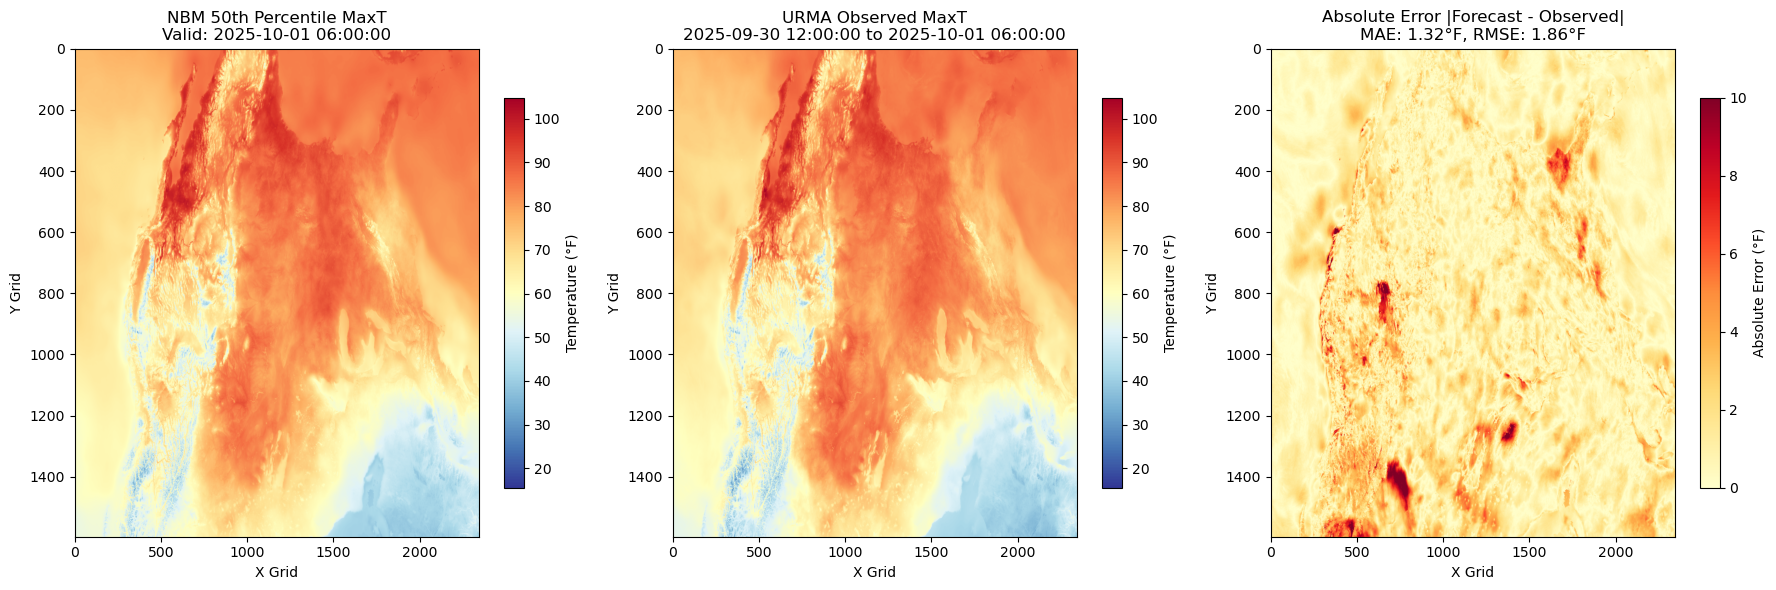


Figure saved to: output/maxt_verification_panels.png


In [36]:
# Three-panel visualization: NBM Forecast, URMA Observed, Absolute Error
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Common colormap limits for temperature (in °F)
temp_min = min(np.nanmin(nbm_maxt_F), np.nanmin(urma_maxt_F))
temp_max = max(np.nanmax(nbm_maxt_F), np.nanmax(urma_maxt_F))

# Panel 1: NBM 50th Percentile MaxT Forecast
im1 = axes[0].imshow(nbm_maxt_F, cmap='RdYlBu_r', vmin=temp_min, vmax=temp_max, 
                      origin='upper', aspect='auto')
axes[0].set_title(f'NBM 50th Percentile MaxT\nValid: {sample_valid_time}', fontsize=12)
axes[0].set_xlabel('X Grid')
axes[0].set_ylabel('Y Grid')
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.8)
cbar1.set_label('Temperature (°F)')

# Panel 2: URMA Observed MaxT
im2 = axes[1].imshow(urma_maxt_F, cmap='RdYlBu_r', vmin=temp_min, vmax=temp_max,
                      origin='upper', aspect='auto')
axes[1].set_title(f'URMA Observed MaxT\n{obs_window_start} to {obs_window_end}', fontsize=12)
axes[1].set_xlabel('X Grid')
axes[1].set_ylabel('Y Grid')
cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.8)
cbar2.set_label('Temperature (°F)')

# Panel 3: Absolute Error
abs_error = np.abs(error_F)
im3 = axes[2].imshow(abs_error, cmap='YlOrRd', vmin=0, vmax=10,
                      origin='upper', aspect='auto')
axes[2].set_title(f'Absolute Error |Forecast - Observed|\nMAE: {mae_F:.2f}°F, RMSE: {rmse_F:.2f}°F', fontsize=12)
axes[2].set_xlabel('X Grid')
axes[2].set_ylabel('Y Grid')
cbar3 = plt.colorbar(im3, ax=axes[2], shrink=0.8)
cbar3.set_label('Absolute Error (°F)')

plt.tight_layout()
plt.savefig('output/maxt_verification_panels.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: output/maxt_verification_panels.png")

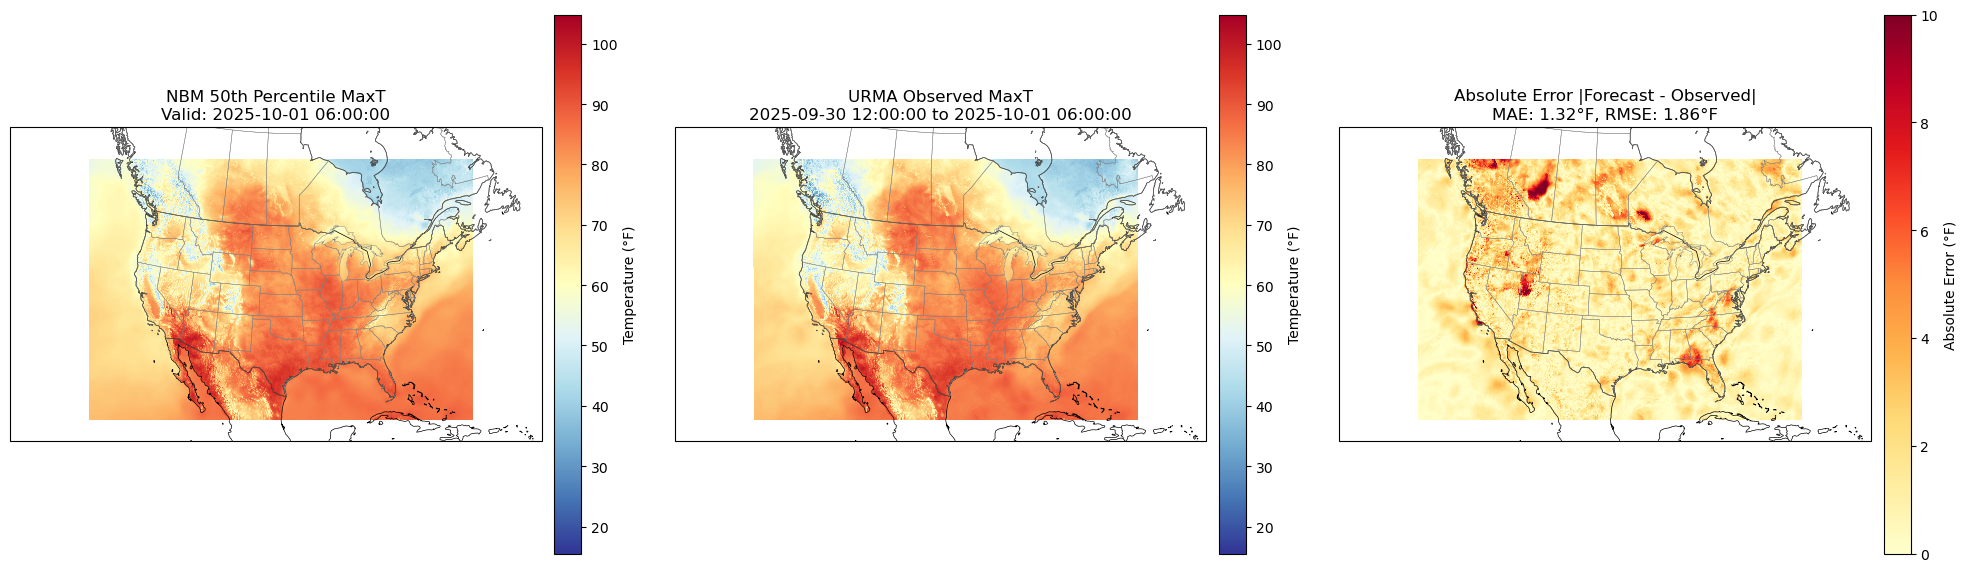


Figure saved to: output/maxt_verification_map.png


In [37]:
# Three-panel map with proper projection and geographic boundaries
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# The NDFD/NBM grid uses Lambert Conformal Conic projection
# Standard parameters for CONUS NDFD grid
ndfd_proj = ccrs.LambertConformal(
    central_longitude=-95.0,
    central_latitude=25.0,
    standard_parallels=(25.0, 25.0)
)

# PlateCarree for the data coordinates (lat/lon)
data_crs = ccrs.PlateCarree()

# Create figure with map projections
fig, axes = plt.subplots(1, 3, figsize=(20, 8), 
                          subplot_kw={'projection': ndfd_proj})

# Common colormap limits for temperature (in °F)
temp_min = min(np.nanmin(nbm_maxt_F), np.nanmin(urma_maxt_F))
temp_max = max(np.nanmax(nbm_maxt_F), np.nanmax(urma_maxt_F))

# Get extent from the lat/lon arrays
lon_min, lon_max = nbm_lons.min(), nbm_lons.max()
lat_min, lat_max = nbm_lats.min(), nbm_lats.max()

def add_map_features(ax):
    """Add geographic features to a map axis"""
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='gray')
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=data_crs)

# Panel 1: NBM 50th Percentile MaxT Forecast
im1 = axes[0].pcolormesh(nbm_lons, nbm_lats, nbm_maxt_F, 
                          cmap='RdYlBu_r', vmin=temp_min, vmax=temp_max,
                          transform=data_crs, shading='auto')
add_map_features(axes[0])
axes[0].set_title(f'NBM 50th Percentile MaxT\nValid: {sample_valid_time}', fontsize=12)
cbar1 = plt.colorbar(im1, ax=axes[0], shrink=0.7, pad=0.02)
cbar1.set_label('Temperature (°F)')

# Panel 2: URMA Observed MaxT
im2 = axes[1].pcolormesh(nbm_lons, nbm_lats, urma_maxt_F,
                          cmap='RdYlBu_r', vmin=temp_min, vmax=temp_max,
                          transform=data_crs, shading='auto')
add_map_features(axes[1])
axes[1].set_title(f'URMA Observed MaxT\n{obs_window_start} to {obs_window_end}', fontsize=12)
cbar2 = plt.colorbar(im2, ax=axes[1], shrink=0.7, pad=0.02)
cbar2.set_label('Temperature (°F)')

# Panel 3: Absolute Error
abs_error = np.abs(error_F)
im3 = axes[2].pcolormesh(nbm_lons, nbm_lats, abs_error,
                          cmap='YlOrRd', vmin=0, vmax=10,
                          transform=data_crs, shading='auto')
add_map_features(axes[2])
axes[2].set_title(f'Absolute Error |Forecast - Observed|\nMAE: {mae_F:.2f}°F, RMSE: {rmse_F:.2f}°F', fontsize=12)
cbar3 = plt.colorbar(im3, ax=axes[2], shrink=0.7, pad=0.02)
cbar3.set_label('Absolute Error (°F)')

plt.tight_layout()
plt.savefig('output/maxt_verification_map.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nFigure saved to: output/maxt_verification_map.png")

## Step 12: Memory-Efficient Batch Verification

For computing statistics over a date range (Sept 1 - Nov 30, 2025), we need to:
1. **Process one valid time at a time** - don't hold all grids in memory
2. **Use running statistics** - accumulate sums, not raw values
3. **Clear memory between iterations** - explicit garbage collection

We'll accumulate at each grid point:
- `error_sum` → for Mean Error (bias)
- `abs_error_sum` → for MAE
- `squared_error_sum` → for RMSE
- `count` → number of valid comparisons

Then compute final statistics from the accumulators.

In [38]:
import gc
from typing import Optional, Tuple
from nbm_grib_tools import index_nbm5_grib

def load_urma_maxt_for_window(obs_start: datetime, obs_end: datetime, 
                               urma_catalog: dict) -> Optional[np.ndarray]:
    """
    Load URMA T2m grids for a time window and compute observed MaxT.
    Memory efficient: loads one hour at a time and computes running max.
    
    Returns None if insufficient data available.
    """
    # Convert pandas Timestamps to datetime if needed (for catalog lookup)
    if hasattr(obs_start, 'to_pydatetime'):
        obs_start = obs_start.to_pydatetime()
    if hasattr(obs_end, 'to_pydatetime'):
        obs_end = obs_end.to_pydatetime()
    
    # Generate needed hours
    hours_needed = []
    current = obs_start
    while current <= obs_end:
        hours_needed.append(current)
        current += timedelta(hours=1)
    
    # Initialize running max (will be set on first valid load)
    running_max = None
    hours_loaded = 0
    
    for hour in hours_needed:
        if hour not in urma_catalog:
            continue
        if '2dvaranl_ndfd' not in urma_catalog[hour]:
            continue
            
        urma_file = urma_catalog[hour]['2dvaranl_ndfd']['filepath']
        
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                ds = xr.open_dataset(urma_file, engine='cfgrib',
                                     backend_kwargs={'filter_by_keys': 
                                                     {'typeOfLevel': 'heightAboveGround', 'level': 2}})
            
            # Find T2m variable
            t2m_var = None
            for var_name in ['t2m', 't', '2t']:
                if var_name in ds.data_vars:
                    t2m_var = var_name
                    break
            
            if t2m_var:
                t2m_grid = ds[t2m_var].values
                if running_max is None:
                    running_max = t2m_grid.copy()
                else:
                    running_max = np.maximum(running_max, t2m_grid)
                hours_loaded += 1
            
            ds.close()
            
        except Exception:
            continue
    
    # Require at least 75% of hours to be valid
    if hours_loaded < len(hours_needed) * 0.75:
        return None
    
    return running_max


def load_nbm_maxt_50pct(nbm_file: Path) -> Tuple[Optional[np.ndarray], Optional[dict]]:
    """
    Load the 50th percentile MaxT from an NBM maxt_qmd file.
    Returns (grid, metadata) or (None, None) on failure.
    """
    try:
        # First, index the file to find the 50th percentile message
        idx = index_nbm5_grib(nbm_file)
        pct50_row = idx[idx['percentile'] == 50]
        
        if len(pct50_row) == 0:
            return None, None
        
        msg_id = pct50_row.iloc[0]['msg_id']
        valid_time = pct50_row.iloc[0]['valid_time']
        step_range = pct50_row.iloc[0]['stepRange']
        
        # Read the specific message
        with open(nbm_file, 'rb') as f:
            msg_count = 0
            while True:
                gid = eccodes.codes_grib_new_from_file(f)
                if gid is None:
                    break
                msg_count += 1
                
                if msg_count == msg_id:
                    values = eccodes.codes_get_values(gid)
                    ni = eccodes.codes_get(gid, 'Ni')
                    nj = eccodes.codes_get(gid, 'Nj')
                    grid = values.reshape(nj, ni)
                    eccodes.codes_release(gid)
                    
                    metadata = {
                        'valid_time': valid_time,
                        'step_range': step_range,
                        'file': nbm_file
                    }
                    return grid, metadata
                
                eccodes.codes_release(gid)
        
        return None, None
        
    except Exception:
        return None, None


def get_obs_window_from_step_range(valid_time: datetime, step_range: str) -> Tuple[datetime, datetime]:
    """Calculate observation window from valid time and step range."""
    step_start, step_end = map(int, step_range.split('-'))
    period_hours = step_end - step_start
    obs_start = valid_time - timedelta(hours=period_hours)
    obs_end = valid_time
    return obs_start, obs_end


print("Memory-efficient loading functions defined:")
print("  • load_urma_maxt_for_window() - loads hourly T2m and computes running max")
print("  • load_nbm_maxt_50pct() - loads 50th percentile from NBM file")
print("  • get_obs_window_from_step_range() - calculates URMA time window")

Memory-efficient loading functions defined:
  • load_urma_maxt_for_window() - loads hourly T2m and computes running max
  • load_nbm_maxt_50pct() - loads 50th percentile from NBM file
  • get_obs_window_from_step_range() - calculates URMA time window


In [39]:
def find_nbm_maxt_files_for_valid_range(nbm_path: Path, start_date: datetime, end_date: datetime,
                                         lead_hour: int = 30) -> list:
    """
    Find all NBM maxt_qmd files with valid times in the specified range.
    
    For MaxT with 06Z valid time:
    - lead_hour 30 means 00Z init → valid 06Z next day
    - To get valid times from start_date to end_date, we need init dates
      from (start_date - 1 day) to (end_date - 1 day) for 00Z cycle
    
    Returns list of (file_path, expected_valid_time) tuples.
    """
    results = []
    
    # For f030 files from 00Z cycle, valid time is init_date + 30 hours = next day 06Z
    # So init_date should be (valid_date - 1 day)
    
    current_date = start_date
    while current_date <= end_date:
        # For a target valid time of current_date 06Z,
        # we need init from (current_date - 1 day) 00Z
        init_date = current_date - timedelta(days=1)
        init_date_str = init_date.strftime("%Y%m%d")
        
        # Look for the file
        nbm_file = nbm_path / init_date_str / "00" / f"maxt_qmd_f{lead_hour:03d}.grib2"
        
        if nbm_file.exists():
            expected_valid = datetime(current_date.year, current_date.month, current_date.day, 6, 0, 0)
            results.append((nbm_file, expected_valid))
        
        current_date += timedelta(days=1)
    
    return results


# Test: Find all MaxT files for our date range
start_date = datetime(2025, 9, 1)
end_date = datetime(2025, 11, 30)

maxt_files_for_range = find_nbm_maxt_files_for_valid_range(NBM_PATH, start_date, end_date, lead_hour=30)

print(f"Date range: {start_date.date()} to {end_date.date()}")
print(f"Found {len(maxt_files_for_range)} NBM MaxT files")

if maxt_files_for_range:
    print(f"\nFirst file: {maxt_files_for_range[0][0].name}")
    print(f"  Expected valid: {maxt_files_for_range[0][1]}")
    print(f"\nLast file: {maxt_files_for_range[-1][0].name}")
    print(f"  Expected valid: {maxt_files_for_range[-1][1]}")

Date range: 2025-09-01 to 2025-11-30
Found 82 NBM MaxT files

First file: maxt_qmd_f030.grib2
  Expected valid: 2025-09-08 06:00:00

Last file: maxt_qmd_f030.grib2
  Expected valid: 2025-11-30 06:00:00


In [40]:
def compute_batch_verification_stats(nbm_path: Path, urma_catalog: dict,
                                      start_date: datetime, end_date: datetime,
                                      lead_hour: int = 30,
                                      grid_shape: tuple = (1597, 2345)) -> dict:
    """
    Compute verification statistics over a date range using running accumulators.
    
    Memory efficient: processes one valid time at a time, accumulates sums.
    
    Returns dict with:
        - Grid-based stats: ME, MAE, RMSE at each grid point
        - Domain-wide stats: single values for the whole domain
        - Metadata: dates processed, files used, etc.
    """
    # Initialize accumulators (float64 for numerical stability)
    error_sum = np.zeros(grid_shape, dtype=np.float64)
    abs_error_sum = np.zeros(grid_shape, dtype=np.float64)
    squared_error_sum = np.zeros(grid_shape, dtype=np.float64)
    count = np.zeros(grid_shape, dtype=np.int32)
    
    # For domain-wide running stats
    domain_error_sum = 0.0
    domain_abs_error_sum = 0.0
    domain_squared_error_sum = 0.0
    domain_count = 0
    
    # Find all NBM files for the range
    nbm_files = find_nbm_maxt_files_for_valid_range(nbm_path, start_date, end_date, lead_hour)
    
    processed = 0
    skipped = 0
    
    print(f"Processing {len(nbm_files)} valid times...")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    print()
    
    for i, (nbm_file, expected_valid) in enumerate(tqdm(nbm_files, desc="Processing")):
        try:
            # Load NBM forecast
            nbm_grid, metadata = load_nbm_maxt_50pct(nbm_file)
            if nbm_grid is None:
                skipped += 1
                continue
            
            # Get observation window
            obs_start, obs_end = get_obs_window_from_step_range(
                metadata['valid_time'], metadata['step_range']
            )
            
            # Load URMA observed MaxT
            urma_grid = load_urma_maxt_for_window(obs_start, obs_end, urma_catalog)
            if urma_grid is None:
                skipped += 1
                continue
            
            # Compute errors (in Kelvin for consistency, convert to F at end)
            error = nbm_grid - urma_grid
            
            # Update accumulators (only where both grids are valid)
            valid = ~np.isnan(error)
            
            error_sum[valid] += error[valid]
            abs_error_sum[valid] += np.abs(error[valid])
            squared_error_sum[valid] += error[valid] ** 2
            count[valid] += 1
            
            # Domain-wide accumulation
            domain_error_sum += np.nansum(error)
            domain_abs_error_sum += np.nansum(np.abs(error))
            domain_squared_error_sum += np.nansum(error ** 2)
            domain_count += np.sum(valid)
            
            processed += 1
            
            # Explicit cleanup
            del nbm_grid, urma_grid, error, valid
            gc.collect()
            
        except Exception as e:
            skipped += 1
            continue
    
    print(f"\nProcessed: {processed} valid times")
    print(f"Skipped: {skipped} valid times")
    
    # Compute final statistics
    # Avoid division by zero
    count_safe = np.where(count > 0, count, 1)
    
    # Grid-based stats (in Kelvin)
    me_grid = error_sum / count_safe
    mae_grid = abs_error_sum / count_safe
    rmse_grid = np.sqrt(squared_error_sum / count_safe)
    
    # Set to NaN where no data
    me_grid[count == 0] = np.nan
    mae_grid[count == 0] = np.nan
    rmse_grid[count == 0] = np.nan
    
    # Domain-wide stats (in Kelvin)
    domain_me = domain_error_sum / domain_count if domain_count > 0 else np.nan
    domain_mae = domain_abs_error_sum / domain_count if domain_count > 0 else np.nan
    domain_rmse = np.sqrt(domain_squared_error_sum / domain_count) if domain_count > 0 else np.nan
    
    # Convert to Fahrenheit
    k_to_f_factor = 1.8  # K difference to F difference
    
    return {
        'grid_stats': {
            'me_K': me_grid,
            'mae_K': mae_grid,
            'rmse_K': rmse_grid,
            'me_F': me_grid * k_to_f_factor,
            'mae_F': mae_grid * k_to_f_factor,
            'rmse_F': rmse_grid * k_to_f_factor,
            'count': count
        },
        'domain_stats': {
            'me_K': domain_me,
            'mae_K': domain_mae,
            'rmse_K': domain_rmse,
            'me_F': domain_me * k_to_f_factor,
            'mae_F': domain_mae * k_to_f_factor,
            'rmse_F': domain_rmse * k_to_f_factor,
            'count': domain_count
        },
        'metadata': {
            'start_date': start_date,
            'end_date': end_date,
            'lead_hour': lead_hour,
            'files_processed': processed,
            'files_skipped': skipped
        }
    }

print("Batch verification function defined: compute_batch_verification_stats()")

Batch verification function defined: compute_batch_verification_stats()


In [41]:
# Run batch verification for Sept 1 - Nov 30, 2025
# This will take a while but is memory-efficient

start_date = datetime(2025, 9, 1)
end_date = datetime(2025, 11, 30)

print("=" * 80)
print("NBM MaxT Batch Verification")
print("=" * 80)
print(f"Valid time range: {start_date.date()} to {end_date.date()}")
print(f"Lead time: f030 (Day 1 MaxT from 00Z cycle)")
print()

batch_results = compute_batch_verification_stats(
    NBM_PATH, 
    urma_catalog_full,
    start_date, 
    end_date,
    lead_hour=30
)

print("\n" + "=" * 80)
print("BATCH VERIFICATION RESULTS")
print("=" * 80)
print(f"\nDomain-Wide Statistics:")
print(f"  Mean Error (Bias): {batch_results['domain_stats']['me_F']:.3f} °F")
print(f"  Mean Absolute Error: {batch_results['domain_stats']['mae_F']:.3f} °F")
print(f"  Root Mean Square Error: {batch_results['domain_stats']['rmse_F']:.3f} °F")
print(f"\n  Total grid-point comparisons: {batch_results['domain_stats']['count']:,}")
print(f"  Files processed: {batch_results['metadata']['files_processed']}")
print(f"  Files skipped: {batch_results['metadata']['files_skipped']}")

NBM MaxT Batch Verification
Valid time range: 2025-09-01 to 2025-11-30
Lead time: f030 (Day 1 MaxT from 00Z cycle)

Processing 82 valid times...
Date range: 2025-09-01 to 2025-11-30



Processing:   0%|          | 0/82 [00:00<?, ?it/s]

[nbm_grib_tools] Indexing N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250907\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250907\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250907\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250908\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250908\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250908\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250908\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250909\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250909\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250909\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250909\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250910\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250910\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250910\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250910\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250911\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250911\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250911\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250911\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250912\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250912\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250912\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250912\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250913\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250913\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250913\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250913\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250914\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250914\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250914\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250914\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250915\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250915\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250915\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250915\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250916\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250916\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250916\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250916\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250917\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250917\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250917\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250917\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250918\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250918\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250918\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250918\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250919\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250919\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250919\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250919\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250920\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250920\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250920\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250920\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250921\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250921\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250921\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250921\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250922\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250922\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250922\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250922\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250923\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250923\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250923\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250923\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250924\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250924\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250924\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250924\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250925\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250925\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250925\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250925\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250926\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250926\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250926\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250926\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250927\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250927\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250927\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250927\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250928\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250928\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250928\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250928\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250929\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250929\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250929\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250929\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20250930\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250930\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251001\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251001\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251001\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251001\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251002\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251002\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251002\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251002\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251003\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251003\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251003\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251003\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251004\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251004\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251004\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251004\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251005\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251005\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251005\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251005\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251006\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251006\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251006\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251006\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251007\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251007\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251007\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251007\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251008\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251008\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251008\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251008\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251009\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251009\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251009\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251009\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251010\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251010\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251010\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251010\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251011\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251011\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251011\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251011\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251012\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251012\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251012\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251012\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251013\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251013\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251013\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251013\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251014\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251014\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251014\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251014\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251015\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251015\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251015\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251015\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251016\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251016\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251016\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251016\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251017\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251017\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251017\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251017\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251018\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251018\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251018\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251018\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251019\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251019\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251019\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251019\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251020\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251020\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251020\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251020\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251021\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251021\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251021\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251021\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251022\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251022\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251022\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251022\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251023\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251023\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251023\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251023\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251026\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251026\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251026\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251026\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251027\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251027\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251027\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251027\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251028\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251028\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251028\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251028\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251029\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251029\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251029\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251029\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251030\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251030\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251030\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251030\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251031\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251031\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251031\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251031\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251101\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251101\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251101\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251101\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251102\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251102\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251102\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251102\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251103\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251103\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251103\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251103\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251104\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251104\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251104\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251104\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251105\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251105\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251105\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251105\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251106\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251106\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251106\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251106\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251107\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251107\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251107\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251107\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251108\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251108\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251108\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251108\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251109\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251109\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251109\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251109\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251110\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251110\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251110\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251110\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251111\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251111\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251111\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251111\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251112\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251112\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251112\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251112\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251113\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251113\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251113\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251113\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251114\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251114\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251114\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251114\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251115\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251115\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251115\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251115\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251116\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251116\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251116\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251116\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251117\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251117\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251117\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251117\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251118\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251118\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251118\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251118\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251119\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251119\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251119\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251119\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251120\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251120\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251120\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251120\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251121\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251121\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251121\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251121\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251122\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251122\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251122\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251122\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251123\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251123\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251123\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251123\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251124\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251124\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251124\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251124\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251125\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251125\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251125\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251125\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251126\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251126\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251126\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251126\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251127\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251127\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251127\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251127\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251128\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251128\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251128\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251128\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

[nbm_grib_tools] Indexing N:\data\nbm_para\20251129\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20251129\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20251129\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20251129\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic


Processed: 82 valid times
Skipped: 0 valid times

BATCH VERIFICATION RESULTS

Domain-Wide Statistics:
  Mean Error (Bias): 0.360 °F
  Mean Absolute Error: 1.421 °F
  Root Mean Square Error: 2.005 °F

  Total grid-point comparisons: 307,087,130
  Files processed: 82
  Files skipped: 0


In [42]:
# Debug: Check why files are being skipped
# Test with one file from our range

test_file, test_valid = maxt_files_for_range[0]
print(f"Test file: {test_file}")
print(f"Expected valid: {test_valid}")

# Load NBM
nbm_grid, metadata = load_nbm_maxt_50pct(test_file)
print(f"\nNBM loaded: {nbm_grid is not None}")
if metadata:
    print(f"  Valid time from file: {metadata['valid_time']}")
    print(f"  Step range: {metadata['step_range']}")
    
    obs_start, obs_end = get_obs_window_from_step_range(metadata['valid_time'], metadata['step_range'])
    print(f"\n  Obs window start: {obs_start}")
    print(f"  Obs window end: {obs_end}")
    print(f"  Type of obs_start: {type(obs_start)}")
    
    # Check URMA catalog keys
    sample_urma_key = list(urma_catalog_full.keys())[0]
    print(f"\n  Sample URMA catalog key: {sample_urma_key}")
    print(f"  Type of URMA key: {type(sample_urma_key)}")
    
    # Check if obs_start is in catalog
    print(f"\n  obs_start in catalog: {obs_start in urma_catalog_full}")
    
    # Try converting
    if hasattr(obs_start, 'to_pydatetime'):
        obs_start_py = obs_start.to_pydatetime()
        print(f"  obs_start (converted): {obs_start_py}")
        print(f"  obs_start (converted) in catalog: {obs_start_py in urma_catalog_full}")

Test file: N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2
Expected valid: 2025-09-08 06:00:00
[nbm_grib_tools] Indexing N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2...

NBM loaded: True
  Valid time from file: 2025-09-08 06:00:00
  Step range: 12-30

  Obs window start: 2025-09-07 12:00:00
  Obs window end: 2025-09-08 06:00:00
  Type of obs_start: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

  Sample URMA catalog key: 2022-01-01 04:00:00
  Type of URMA key: <class 'datetime.datetime'>

  obs_start in catalog: True
  obs_start (converted): 2025-09-07 12:00:00
  obs_start (converted) in catalog: True


In [43]:
# Import the helper and debug NBM loading
from nbm_grib_tools import index_nbm5_grib

test_file = maxt_files_for_range[0][0]
print(f"Testing: {test_file}")
print(f"File exists: {test_file.exists()}")

try:
    # Try indexing
    idx = index_nbm5_grib(test_file)
    print(f"\nIndex successful: {len(idx)} messages")
    print(idx[['msg_id', 'param_type', 'percentile', 'name']].head(10))
    
    # Find 50th percentile
    pct50 = idx[idx['percentile'] == 50]
    print(f"\n50th percentile rows: {len(pct50)}")
    if len(pct50) > 0:
        print(pct50[['msg_id', 'valid_time', 'stepRange']])
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

Testing: N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2
File exists: True
[nbm_grib_tools] Indexing N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2...

Index successful: 13 messages
   msg_id   param_type  percentile                              name
0       1  Probability         NaN  Time-maximum 2 metre temperature
1       2  Probability         NaN  Time-maximum 2 metre temperature
2       3  Probability         NaN  Time-maximum 2 metre temperature
3       4  Probability         NaN  Time-maximum 2 metre temperature
4       5  Probability         NaN  Time-maximum 2 metre temperature
5       6   Percentile         5.0  Time-maximum 2 metre temperature
6       7   Percentile        10.0  Time-maximum 2 metre temperature
7       8   Percentile        25.0  Time-maximum 2 metre temperature
8       9   Percentile        50.0  Time-maximum 2 metre temperature
9      10   Percentile        75.0  Time-maximum 2 metre temperature

50th percentile rows: 1
   msg_id          valid_time s

In [44]:
# Test the fixed NBM loading function
test_file = maxt_files_for_range[0][0]
nbm_grid, metadata = load_nbm_maxt_50pct(test_file)

print(f"NBM loaded: {nbm_grid is not None}")
if metadata:
    print(f"Valid time: {metadata['valid_time']}")
    print(f"Step range: {metadata['step_range']}")
    print(f"Grid shape: {nbm_grid.shape}")
    
    # Get obs window
    obs_start, obs_end = get_obs_window_from_step_range(metadata['valid_time'], metadata['step_range'])
    print(f"\nObs window: {obs_start} to {obs_end}")
    print(f"Type: {type(obs_start)}")
    
    # Check URMA catalog - need to handle Timestamp vs datetime
    # Convert to standard datetime if needed
    if hasattr(obs_start, 'to_pydatetime'):
        obs_start_dt = obs_start.to_pydatetime()
    else:
        obs_start_dt = obs_start
    
    # Check catalog keys
    sample_key = list(urma_catalog_full.keys())[0]
    print(f"\nURMA catalog key type: {type(sample_key)}")
    print(f"Sample key: {sample_key}")
    print(f"obs_start_dt in catalog: {obs_start_dt in urma_catalog_full}")

[nbm_grib_tools] Indexing N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2...
NBM loaded: True
Valid time: 2025-09-08 06:00:00
Step range: 12-30
Grid shape: (1597, 2345)

Obs window: 2025-09-07 12:00:00 to 2025-09-08 06:00:00
Type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>

URMA catalog key type: <class 'datetime.datetime'>
Sample key: 2022-01-01 04:00:00
obs_start_dt in catalog: True


In [45]:
# Test full verification pair with the fixed function
test_file = maxt_files_for_range[0][0]

# Load NBM
nbm_grid, metadata = load_nbm_maxt_50pct(test_file)
print(f"NBM loaded: {nbm_grid is not None}, shape: {nbm_grid.shape if nbm_grid is not None else 'N/A'}")

# Get obs window
obs_start, obs_end = get_obs_window_from_step_range(metadata['valid_time'], metadata['step_range'])
print(f"Obs window: {obs_start} to {obs_end}")

# Load URMA
urma_grid = load_urma_maxt_for_window(obs_start, obs_end, urma_catalog_full)
print(f"URMA loaded: {urma_grid is not None}, shape: {urma_grid.shape if urma_grid is not None else 'N/A'}")

if nbm_grid is not None and urma_grid is not None:
    # Compute error
    error = nbm_grid - urma_grid
    error_F = error * 1.8
    print(f"\nError computed successfully!")
    print(f"  ME: {np.nanmean(error_F):.3f} °F")
    print(f"  MAE: {np.nanmean(np.abs(error_F)):.3f} °F")
    print(f"  RMSE: {np.sqrt(np.nanmean(error_F**2)):.3f} °F")

[nbm_grib_tools] Indexing N:\data\nbm_para\20250907\00\maxt_qmd_f030.grib2...


Can't create file 'N:\\data\\urma\\20250907\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250907\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250907\\urma2p5.t12z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

NBM loaded: True, shape: (1597, 2345)
Obs window: 2025-09-07 12:00:00 to 2025-09-08 06:00:00


Can't create file 'N:\\data\\urma\\20250907\\urma2p5.t13z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 538, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
         ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\contextlib.py", line 141, in __enter__
    return next(self.gen)
  File "c:\Users\michael.wessler\AppData\Local\anaconda3\envs\nbmv5\Lib\site-packages\cfgrib\messages.py", line 504, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: 'N:\\data\\urma\\20250907\\urma2p5.t13z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Can't read index file 'N:\\data\\urma\\20250907\\urma2p5.t13z.2dvaranl_ndfd.wexp.grb2.da267.idx'
Traceback (most recent call last):
  File "c:\Users\mic

URMA loaded: True, shape: (1597, 2345)

Error computed successfully!
  ME: 0.499 °F
  MAE: 1.530 °F
  RMSE: 2.130 °F


## Optimized Loading Functions

The original functions had several inefficiencies:
1. **NBM**: Indexed all 13 messages just to find the 50th percentile (always message #6)
2. **URMA**: Used xarray/cfgrib overhead for simple GRIB reads
3. **Excessive gc.collect()** calls adding overhead

The optimized versions use direct `eccodes` reads for ~5-10× speedup.

In [46]:
# Suppress all warnings and unnecessary output
import warnings
import logging

warnings.filterwarnings('ignore')
logging.getLogger('cfgrib').setLevel(logging.ERROR)
logging.getLogger('eccodes').setLevel(logging.ERROR)

# Suppress eccodes info messages
import os
os.environ['ECCODES_DEBUG'] = '0'

# Ensure notebook-friendly progress bars
from tqdm.auto import tqdm

def load_nbm_maxt_50pct_fast(nbm_file: Path) -> Tuple[Optional[np.ndarray], Optional[dict]]:
    """
    OPTIMIZED: Direct read of message #6 (50th percentile) - skip indexing.
    
    The 50th percentile is always message #6 in maxt_qmd files.
    This avoids scanning all 13 messages just to find it.
    """
    try:
        with open(nbm_file, 'rb') as f:
            # Read through to message #6
            for i in range(6):
                gid = eccodes.codes_grib_new_from_file(f)
                if gid is None:
                    return None, None
                if i < 5:
                    eccodes.codes_release(gid)
            
            # Message 6 is the 50th percentile
            values = eccodes.codes_get_values(gid)
            ni = eccodes.codes_get(gid, 'Ni')
            nj = eccodes.codes_get(gid, 'Nj')
            
            # Get validity time directly from GRIB keys
            valid_date = eccodes.codes_get(gid, 'validityDate')  # YYYYMMDD as int
            valid_time = eccodes.codes_get(gid, 'validityTime')  # HHMM as int
            step_range = eccodes.codes_get(gid, 'stepRange')
            
            eccodes.codes_release(gid)
            
            grid = values.reshape(nj, ni)
            vt = datetime.strptime(f"{valid_date}{valid_time:04d}", "%Y%m%d%H%M")
            
            return grid, {'valid_time': vt, 'step_range': step_range, 'file': nbm_file}
            
    except Exception as e:
        return None, None


def load_urma_t2m_fast(urma_file: Path) -> Optional[np.ndarray]:
    """
    OPTIMIZED: Direct eccodes read of T2m - skip xarray/cfgrib overhead.
    
    Scans messages looking for 2m temperature (heightAboveGround, level=2).
    Much faster than xr.open_dataset with cfgrib engine.
    """
    try:
        with open(urma_file, 'rb') as f:
            while True:
                gid = eccodes.codes_grib_new_from_file(f)
                if gid is None:
                    break
                
                # Check if this is the 2m temperature message
                try:
                    level = eccodes.codes_get(gid, 'level')
                    type_of_level = eccodes.codes_get(gid, 'typeOfLevel')
                    short_name = eccodes.codes_get(gid, 'shortName')
                    
                    if level == 2 and type_of_level == 'heightAboveGround' and short_name in ['2t', 't2m', 't']:
                        values = eccodes.codes_get_values(gid)
                        ni = eccodes.codes_get(gid, 'Ni')
                        nj = eccodes.codes_get(gid, 'Nj')
                        eccodes.codes_release(gid)
                        return values.reshape(nj, ni)
                except:
                    pass
                
                eccodes.codes_release(gid)
        
        return None
    except:
        return None


def load_urma_maxt_for_window_fast(obs_start: datetime, obs_end: datetime, 
                                    urma_catalog: dict) -> Optional[np.ndarray]:
    """
    OPTIMIZED: Load URMA T2m grids and compute observed MaxT using fast direct reads.
    """
    # Convert pandas Timestamps to datetime if needed
    if hasattr(obs_start, 'to_pydatetime'):
        obs_start = obs_start.to_pydatetime()
    if hasattr(obs_end, 'to_pydatetime'):
        obs_end = obs_end.to_pydatetime()
    
    # Generate needed hours
    hours_needed = []
    current = obs_start
    while current <= obs_end:
        hours_needed.append(current)
        current += timedelta(hours=1)
    
    # Initialize running max
    running_max = None
    hours_loaded = 0
    
    for hour in hours_needed:
        if hour not in urma_catalog:
            continue
        if '2dvaranl_ndfd' not in urma_catalog[hour]:
            continue
            
        urma_file = urma_catalog[hour]['2dvaranl_ndfd']['filepath']
        t2m_grid = load_urma_t2m_fast(urma_file)
        
        if t2m_grid is not None:
            if running_max is None:
                running_max = t2m_grid.copy()
            else:
                running_max = np.maximum(running_max, t2m_grid)
            hours_loaded += 1
    
    # Require at least 75% of hours to be valid
    if hours_loaded < len(hours_needed) * 0.75:
        return None
    
    return running_max


print("Optimized loading functions defined:")
print("  • load_nbm_maxt_50pct_fast() - direct message #6 read, no indexing")
print("  • load_urma_t2m_fast() - direct eccodes read, no xarray overhead")
print("  • load_urma_maxt_for_window_fast() - uses fast URMA loader")

Optimized loading functions defined:
  • load_nbm_maxt_50pct_fast() - direct message #6 read, no indexing
  • load_urma_t2m_fast() - direct eccodes read, no xarray overhead
  • load_urma_maxt_for_window_fast() - uses fast URMA loader


In [47]:
def compute_batch_verification_stats_fast(nbm_path: Path, urma_catalog: dict,
                                          start_date: datetime, end_date: datetime,
                                          lead_hour: int = 30,
                                          grid_shape: tuple = (1597, 2345)) -> dict:
    """
    OPTIMIZED: Compute verification statistics using fast loaders.
    
    Changes from original:
    - Uses load_nbm_maxt_50pct_fast() - skips indexing
    - Uses load_urma_maxt_for_window_fast() - direct eccodes reads
    - Removed excessive gc.collect() calls
    """
    # Initialize accumulators
    error_sum = np.zeros(grid_shape, dtype=np.float64)
    abs_error_sum = np.zeros(grid_shape, dtype=np.float64)
    squared_error_sum = np.zeros(grid_shape, dtype=np.float64)
    count = np.zeros(grid_shape, dtype=np.int32)
    
    # Domain-wide running stats
    domain_error_sum = 0.0
    domain_abs_error_sum = 0.0
    domain_squared_error_sum = 0.0
    domain_count = 0
    
    # Find all NBM files for the range
    nbm_files = find_nbm_maxt_files_for_valid_range(nbm_path, start_date, end_date, lead_hour)
    
    processed = 0
    skipped = 0
    
    print(f"Processing {len(nbm_files)} valid times...")
    print(f"Date range: {start_date.date()} to {end_date.date()}")
    print()
    
    for nbm_file, expected_valid in tqdm(nbm_files, desc="Processing"):
        try:
            # Load NBM forecast (FAST version)
            nbm_grid, metadata = load_nbm_maxt_50pct_fast(nbm_file)
            if nbm_grid is None:
                skipped += 1
                continue
            
            # Get observation window
            obs_start, obs_end = get_obs_window_from_step_range(
                metadata['valid_time'], metadata['step_range']
            )
            
            # Load URMA observed MaxT (FAST version)
            urma_grid = load_urma_maxt_for_window_fast(obs_start, obs_end, urma_catalog)
            if urma_grid is None:
                skipped += 1
                continue
            
            # Compute errors
            error = nbm_grid - urma_grid
            
            # Update accumulators
            valid = ~np.isnan(error)
            
            error_sum[valid] += error[valid]
            abs_error_sum[valid] += np.abs(error[valid])
            squared_error_sum[valid] += error[valid] ** 2
            count[valid] += 1
            
            # Domain-wide accumulation
            domain_error_sum += np.nansum(error)
            domain_abs_error_sum += np.nansum(np.abs(error))
            domain_squared_error_sum += np.nansum(error ** 2)
            domain_count += np.sum(valid)
            
            processed += 1
            
        except Exception:
            skipped += 1
            continue
    
    print(f"\nProcessed: {processed} valid times")
    print(f"Skipped: {skipped} valid times")
    
    # Compute final statistics
    count_safe = np.where(count > 0, count, 1)
    
    me_grid = error_sum / count_safe
    mae_grid = abs_error_sum / count_safe
    rmse_grid = np.sqrt(squared_error_sum / count_safe)
    
    me_grid[count == 0] = np.nan
    mae_grid[count == 0] = np.nan
    rmse_grid[count == 0] = np.nan
    
    # Domain-wide stats
    domain_me = domain_error_sum / domain_count if domain_count > 0 else np.nan
    domain_mae = domain_abs_error_sum / domain_count if domain_count > 0 else np.nan
    domain_rmse = np.sqrt(domain_squared_error_sum / domain_count) if domain_count > 0 else np.nan
    
    # Convert to Fahrenheit (for temperature differences: ΔF = ΔK × 1.8)
    k_to_f_factor = 1.8
    
    return {
        'grid_stats': {
            'me_K': me_grid,
            'mae_K': mae_grid,
            'rmse_K': rmse_grid,
            'me_F': me_grid * k_to_f_factor,
            'mae_F': mae_grid * k_to_f_factor,
            'rmse_F': rmse_grid * k_to_f_factor,
            'count': count
        },
        'domain_stats': {
            'me_K': domain_me,
            'mae_K': domain_mae,
            'rmse_K': domain_rmse,
            'me_F': domain_me * k_to_f_factor,
            'mae_F': domain_mae * k_to_f_factor,
            'rmse_F': domain_rmse * k_to_f_factor,
            'count': domain_count
        },
        'metadata': {
            'start_date': start_date,
            'end_date': end_date,
            'lead_hour': lead_hour,
            'files_processed': processed,
            'files_skipped': skipped
        }
    }

print("Optimized batch function defined: compute_batch_verification_stats_fast()")

Optimized batch function defined: compute_batch_verification_stats_fast()


In [48]:
# Run OPTIMIZED batch verification for Sept 1 - Nov 30, 2025
import time

start_date = datetime(2025, 9, 1)
end_date = datetime(2025, 11, 30)

print("=" * 80)
print("NBM MaxT Batch Verification (OPTIMIZED)")
print("=" * 80)
print(f"Valid time range: {start_date.date()} to {end_date.date()}")
print(f"Lead time: f030 (Day 1 MaxT from 00Z cycle)")
print()

start_time = time.time()

batch_results_fast = compute_batch_verification_stats_fast(
    NBM_PATH, 
    urma_catalog_full,
    start_date, 
    end_date,
    lead_hour=30
)

elapsed = time.time() - start_time

print("\n" + "=" * 80)
print("BATCH VERIFICATION RESULTS (OPTIMIZED)")
print("=" * 80)
print(f"\nDomain-Wide Statistics:")
print(f"  Mean Error (Bias): {batch_results_fast['domain_stats']['me_F']:.3f} °F")
print(f"  Mean Absolute Error: {batch_results_fast['domain_stats']['mae_F']:.3f} °F")
print(f"  Root Mean Square Error: {batch_results_fast['domain_stats']['rmse_F']:.3f} °F")
print(f"\n  Total grid-point comparisons: {batch_results_fast['domain_stats']['count']:,}")
print(f"  Files processed: {batch_results_fast['metadata']['files_processed']}")
print(f"  Files skipped: {batch_results_fast['metadata']['files_skipped']}")
print(f"\n⏱️  Elapsed time: {elapsed:.1f} seconds ({elapsed/60:.1f} minutes)")

NBM MaxT Batch Verification (OPTIMIZED)
Valid time range: 2025-09-01 to 2025-11-30
Lead time: f030 (Day 1 MaxT from 00Z cycle)

Processing 82 valid times...
Date range: 2025-09-01 to 2025-11-30



Processing:   0%|          | 0/82 [00:00<?, ?it/s]


Processed: 82 valid times
Skipped: 0 valid times

BATCH VERIFICATION RESULTS (OPTIMIZED)

Domain-Wide Statistics:
  Mean Error (Bias): -2.752 °F
  Mean Absolute Error: 2.955 °F
  Root Mean Square Error: 4.236 °F

  Total grid-point comparisons: 307,087,130
  Files processed: 82
  Files skipped: 0

⏱️  Elapsed time: 551.5 seconds (9.2 minutes)
